**The code below is to mount google drive, this is a must to run all code below**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**The code below is to print out the performance of the baseline transformer**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.metrics import edit_distance
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import json
import math
import time
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

nltk.download('punkt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts


sequences, texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')

# Func to build a word vocab
def build_vocab(texts):
    words = set()
    for text in texts:
        words.update(text.split())
    vocab = {word: idx for idx, word in enumerate(sorted(words))}
    vocab['<pad>'] = len(vocab)
    return vocab

vocab = build_vocab(texts)
pad_idx = vocab['<pad>']

INPUT_DIM = 1024
EMBED_DIM = 512
NUM_HEADS = 4  # Updated to 4 heads
NUM_LAYERS = 1  # 1 layer
OUTPUT_DIM = len(vocab)
BATCH_SIZE = 64

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(self.dropout(src)))
        tgt = self.positional_encoding(self.layer_norm(self.dropout(tgt)))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long)
        return sequence, text_tokens

def word_tokenizer(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

def decode_text(output, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    decoded_texts = []
    for seq in output:
        decoded_text = ' '.join([inv_vocab[token] for token in seq if token in inv_vocab and inv_vocab[token] != '<pad>'])
        decoded_texts.append(decoded_text)
    return decoded_texts

def evaluate_and_metrics(model, loader, device, vocab, pad_idx):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    correct_predictions = 0
    total_predictions = 0
    all_predicted_tokens = []
    all_target_tokens = []
    sequence_matches = 0
    total_sequences = 0
    total_edit_distance = 0
    references = []
    hypotheses = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])
            loss = criterion(outputs.view(-1, outputs.size(-1)), texts[:, 1:].reshape(-1))
            total_loss += loss.item()

            predicted_tokens = outputs.argmax(dim=-1)
            all_predicted_tokens.extend(predicted_tokens.cpu().numpy().flatten())
            all_target_tokens.extend(texts[:, 1:].cpu().numpy().flatten())

            correct_predictions += (predicted_tokens == texts[:, 1:]).sum().item()
            total_predictions += texts[:, 1:].ne(pad_idx).sum().item()

            for pred_seq, tgt_seq in zip(predicted_tokens.cpu().numpy(), texts[:, 1:].cpu().numpy()):
                total_sequences += 1
                if np.array_equal(pred_seq, tgt_seq):
                    sequence_matches += 1
                total_edit_distance += edit_distance(pred_seq.tolist(), tgt_seq.tolist())

                references.append(decode_text([tgt_seq], vocab))
                hypotheses.append(decode_text([pred_seq], vocab))

    avg_loss = total_loss / len(loader)
    token_accuracy = correct_predictions / total_predictions
    sequence_accuracy = sequence_matches / total_sequences
    avg_edit_distance = total_edit_distance / total_sequences

    precision = precision_score(all_target_tokens, all_predicted_tokens, average='macro', zero_division=0)
    recall = recall_score(all_target_tokens, all_predicted_tokens, average='macro', zero_division=0)
    f1 = f1_score(all_target_tokens, all_predicted_tokens, average='macro', zero_division=0)

    # BLEU scores calc
    smoothing = SmoothingFunction().method4
    bleu_scores = { "BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": [] }
    for ref, hyp in zip(references, hypotheses):
        ref_tokens = nltk.word_tokenize(ref[0])
        hyp_tokens = nltk.word_tokenize(hyp[0])
        bleu_scores["BLEU-1"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-2"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-3"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-4"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

    avg_bleu_scores = { key: np.mean(value) for key, value in bleu_scores.items() }

    # ROUGE scores calc
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = { "ROUGE-1": [], "ROUGE-2": [], "ROUGE-L": [] }
    for ref, hyp in zip(references, hypotheses):
        score = rouge_scorer_inst.score(ref[0], hyp[0])
        rouge_scores["ROUGE-1"].append(score['rouge1'].fmeasure)
        rouge_scores["ROUGE-2"].append(score['rouge2'].fmeasure)
        rouge_scores["ROUGE-L"].append(score['rougeL'].fmeasure)

    avg_rouge_scores = { key: np.mean(value) for key, value in rouge_scores.items() }

    return {
        'avg_loss': avg_loss,
        'token_accuracy': token_accuracy,
        'sequence_accuracy': sequence_accuracy,
        'avg_edit_distance': avg_edit_distance,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'bleu_scores': avg_bleu_scores,
        'rouge_scores': avg_rouge_scores
    }


dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')
test_sequences, test_texts = load_full_data('/content/drive/My Drive/proj/sequences_test.npy', '/content/drive/My Drive/proj/texts_test.json')

dev_dataset = LandmarksDataset(dev_sequences, dev_texts, lambda text: word_tokenizer(text, vocab))
test_dataset = LandmarksDataset(test_sequences, test_texts, lambda text: word_tokenizer(text, vocab))

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)

model = TransformerModel(INPUT_DIM, EMBED_DIM, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM).to(device)
model.load_state_dict(torch.load('/content/drive/My Drive/proj/transformer_1Layer_4Head.pth'))
model.eval()

# Evaluate on dev set
eval_metrics = evaluate_and_metrics(model, dev_loader, device, vocab, pad_idx)
print(f"Validation Loss: {eval_metrics['avg_loss']:.4f}")
print(f"Validation Token Accuracy: {eval_metrics['token_accuracy']:.4f}")
print(f"Validation Sequence Accuracy: {eval_metrics['sequence_accuracy']:.4f}")
print(f"Validation Avg Edit Distance: {eval_metrics['avg_edit_distance']:.4f}")
print(f"Validation Precision: {eval_metrics['precision']:.4f}")
print(f"Validation Recall: {eval_metrics['recall']:.4f}")
print(f"Validation F1-Score: {eval_metrics['f1_score']:.4f}")
for key, value in eval_metrics['bleu_scores'].items():
    print(f"Average Validation {key}: {value:.4f}")
for key, value in eval_metrics['rouge_scores'].items():
    print(f"Average Validation {key}: {value:.4f}")

# Evaluate on test set
test_metrics = evaluate_and_metrics(model, test_loader, device, vocab, pad_idx)
print(f"Test Loss: {test_metrics['avg_loss']:.4f}")
print(f"Test Token Accuracy: {test_metrics['token_accuracy']:.4f}")
print(f"Test Sequence Accuracy: {test_metrics['sequence_accuracy']:.4f}")
print(f"Test Avg Edit Distance: {test_metrics['avg_edit_distance']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")
for key, value in test_metrics['bleu_scores'].items():
    print(f"Average Test {key}: {value:.4f}")
for key, value in test_metrics['rouge_scores'].items():
    print(f"Average Test {key}: {value:.4f}")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Validation Loss: 3.1565
Validation Token Accuracy: 0.4902
Validation Sequence Accuracy: 0.0079
Validation Avg Edit Distance: 8.5323
Validation Precision: 0.3030
Validation Recall: 0.3050
Validation F1-Score: 0.2863
Average Validation BLEU-1: 0.6123
Average Validation BLEU-2: 0.3974
Average Validation BLEU-3: 0.2915
Average Validation BLEU-4: 0.2224
Average Validation ROUGE-1: 0.6352
Average Validation ROUGE-2: 0.3230
Average Validation ROUGE-L: 0.5298
Test Loss: 3.0029
Test Token Accuracy: 0.5288
Test Sequence Accuracy: 0.0136
Test Avg Edit Distance: 7.5362
Test Precision: 0.3368
Test Recall: 0.3440
Test F1-Score: 0.3216
Average Test BLEU-1: 0.6144
Average Test BLEU-2: 0.4199
Average Test BLEU-3: 0.3148
Average Test BLEU-4: 0.2429
Average Test ROUGE-1: 0.6449
Average Test ROUGE-2: 0.3580
Average Test ROUGE-L: 0.5516


**the code is to print out the output of transformer.**

In [ ]:
# to print the outputs of the Transformer model
def print_transformer_outputs(model, data_loader, device):
    model.eval()

    with torch.no_grad():
        for batch_idx, (sequences, texts) in enumerate(data_loader):
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])

            print(f"\n--- Batch {batch_idx + 1} ---")
            print(f"Model raw outputs (logits) - showing all tokens for each sequence:")

            for i in range(outputs.size(0)):
                print(f"\nSequence {batch_idx * data_loader.batch_size + i + 1} - All Outputs:")
                print(outputs[i])

            break

print_transformer_outputs(model, dev_loader, device)



--- Batch 1 ---
Model raw outputs (logits) - showing all tokens for each sequence:

Sequence 1 - All Outputs:
tensor([[-0.4238, -1.2491, -0.0367,  ..., -1.3698,  1.1916,  0.0530],
        [-0.8742,  3.9889, -2.1943,  ..., -1.3684, -0.4017, -0.1432],
        [ 0.0957,  0.8516, -0.4526,  ...,  1.0330,  1.7883, -0.7602],
        ...,
        [-0.4818, -0.8229, -2.2131,  ..., -0.6463,  1.2278, -0.2070],
        [ 0.0255,  1.6957, -0.4236,  ..., -2.3699, -0.3442,  0.5622],
        [ 1.2822, -0.8613, -1.3290,  ..., -2.2086,  1.9136, -0.2560]],
       device='cuda:0')

Sequence 2 - All Outputs:
tensor([[-0.4953, -1.3098,  0.0171,  ..., -1.2967,  1.2720,  0.0159],
        [-0.8543,  3.9405, -2.1875,  ..., -1.3733, -0.3914, -0.1335],
        [ 0.0461,  0.7983, -0.3991,  ...,  1.1394,  1.8144, -0.7948],
        ...,
        [-0.5062, -0.9069, -2.2047,  ..., -0.6077,  1.2308, -0.1907],
        [-0.0329,  1.5504, -0.4308,  ..., -2.4660, -0.3131,  0.5504],
        [ 1.2337, -0.9505, -1.2984,  ...,

**The code below is to reverse the output of transformer into text (meaningful sentences)**

In [ ]:

inverse_vocab = {idx: word for word, idx in vocab.items()}

def logits_to_sentence(logits, inverse_vocab):
    token_ids = logits.argmax(dim=-1)

    words = [inverse_vocab.get(token_id.item(), '<unk>') for token_id in token_ids]

    sentence = ' '.join(words).split('<pad>')[0].strip()  # Removing padding and stripping excess spaces
    return sentence

def print_model_predictions(model, data_loader, inverse_vocab, device, num_sentences=200): # print out just 200 sentences
    model.eval()
    sentences = []

    with torch.no_grad():
        for sequences, texts in data_loader:
            sequences = sequences.to(device)
            texts = texts.to(device)
            outputs = model(sequences, texts[:, :-1])

            for i in range(outputs.size(0)):
                sentence = logits_to_sentence(outputs[i].cpu(), inverse_vocab)  # run on cpu
                sentences.append(sentence)
                if len(sentences) >= num_sentences:
                    break
            if len(sentences) >= num_sentences:
                break

    for idx, sentence in enumerate(sentences):
        print(f"Sentence {idx + 1}: {sentence}")

model = model.to(device)

print_model_predictions(model, dev_loader, inverse_vocab, device)


Sentence 1: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 2: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 3: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 4: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 5: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 6: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 7: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 8: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 9: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 10: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 11: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 12: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 13: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 14: luftdruck bestimmt in den nächsten tagen unser wetter
Sentence 15: luftdruck bestimmt in den nächsten tagen unser wetter
Sent

**The code below is the same function as above but to reverse all output to text (not just sample)**

In [ ]:
inverse_vocab = {idx: word for word, idx in vocab.items()}

def logits_to_sentence(logits, inverse_vocab):

    token_indices = logits.argmax(dim=-1).cpu().numpy()

    words = [inverse_vocab[idx] for idx in token_indices]

    sentence = ' '.join(words)

    return sentence

def print_transformer_sentences(model, data_loader, inverse_vocab, device):
    model.eval()

    with torch.no_grad():
        for batch_idx, (sequences, texts) in enumerate(data_loader):
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])

            print(f"\n--- Batch {batch_idx + 1} ---")

            for i in range(outputs.size(0)):
                sentence = logits_to_sentence(outputs[i], inverse_vocab)
                print(f"Sentence {batch_idx * data_loader.batch_size + i + 1}: {sentence}")

            #break

print_transformer_sentences(model, dev_loader, inverse_vocab, device)


Streaming output truncated to the last 5000 lines.
Sentence 26382: der auch wind aus nord und aus der wind der
Sentence 26383: der auch wind aus nord und aus der wind der
Sentence 26384: der auch wind aus nord und aus der wind der
Sentence 26385: der auch wind aus nord und aus der wind der
Sentence 26386: der auch wind aus nord und aus der wind der
Sentence 26387: der auch wind aus nord und aus der wind der
Sentence 26388: der auch wind aus nord und aus der wind der
Sentence 26389: der auch wind aus nord und aus der wind der
Sentence 26390: der auch wind aus nord und aus der wind der
Sentence 26391: der auch wind aus nord und aus der wind der
Sentence 26392: der auch wind aus nord und aus der wind der
Sentence 26393: der auch wind aus nord und aus der wind der
Sentence 26394: der auch wind aus nord und aus der wind der
Sentence 26395: der auch wind aus nord und aus der wind der
Sentence 26396: der auch wind aus nord und aus der wind der
Sentence 26397: der auch wind aus nord und aus de

In [ ]:
import spacy

nlp = spacy.load('de_core_news_sm')  # Load a small German model in spaCy

def pos_tagging_analysis(generated_sentences, reference_sentences):
    for i, (gen_sentence, ref_sentence) in enumerate(zip(generated_sentences, reference_sentences)):
        gen_doc = nlp(gen_sentence)
        ref_doc = nlp(ref_sentence)

        print(f"\n--- Sentence {i+1} ---")
        print("Generated POS Tags: ", [(token.text, token.pos_) for token in gen_doc])
        print("Reference POS Tags: ", [(token.text, token.pos_) for token in ref_doc])

# Example usage
pos_tagging_analysis(generated_sentences, reference_sentences)


**The code below is to extract generated sentences, and compare with the reference sentences**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import nltk
import math

nltk.download('punkt')

# func to build vocab
def build_vocab(texts):
    words = set()
    for text in texts:
        words.update(text.split())
    vocab = {word: idx for idx, word in enumerate(sorted(words))}
    vocab['<pad>'] = len(vocab)
    return vocab

# func to decode output back to text
def decode_text(output, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    decoded_texts = []
    for seq in output:
        decoded_text = ' '.join([inv_vocab[token] for token in seq if token in inv_vocab and inv_vocab[token] != '<pad>'])
        decoded_texts.append(decoded_text)
    return decoded_texts

# func to extract generated sentences
def extract_generated_sentences(model, loader, device, vocab):
    model.eval()
    generated_sentences = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])

            predicted_tokens = outputs.argmax(dim=-1).cpu().numpy()
            generated_sentences.extend(decode_text(predicted_tokens, vocab))

    return generated_sentences

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load sequence&text from dataset
def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

sequences, texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')


vocab = build_vocab(texts)
pad_idx = vocab['<pad>']

INPUT_DIM = 1024
EMBED_DIM = 512
NUM_HEADS = 4
NUM_LAYERS = 1
OUTPUT_DIM = len(vocab)
BATCH_SIZE = 64

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(self.dropout(src)))
        tgt = self.positional_encoding(self.layer_norm(self.dropout(tgt)))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long)
        return sequence, text_tokens

def word_tokenizer(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')


dev_dataset = LandmarksDataset(dev_sequences, dev_texts, lambda text: word_tokenizer(text, vocab))
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)


model = TransformerModel(INPUT_DIM, EMBED_DIM, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM)
model.load_state_dict(torch.load('/content/drive/My Drive/proj/transformer_1Layer_4Head.pth', map_location=torch.device('cpu')))
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


generated_sentences = extract_generated_sentences(model, dev_loader, device, vocab)

reference_json_path = '/content/drive/My Drive/proj/texts_dev.json'
with open(reference_json_path, 'r') as f:
    reference_sentences = json.load(f)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.





*   **The code below is to print out the generated and reference sentences**
*   **Run the above cell first, then run this cell to print out the resutls.**



In [ ]:
# Print some example generated sentences
for i, sentence in enumerate(generated_sentences[:50]):
    print(f"Generated Sentence {i+1}: {sentence}")
print('\n')

# Print some example reference sentences
for i, sentence in enumerate(reference_sentences[:50]):
    print(f"Reference Sentence {i+1}: {sentence}")

Generated Sentence 1: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 2: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 3: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 4: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 5: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 6: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 7: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 8: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 9: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 10: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 11: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 12: luftdruck bestimmt in den nächsten tagen unser wetter
Generated Sentence 13: luftdruck bestimmt in den nächsten tagen unser wetter
Generate

**The code below is to check alignment of gen and ref sentences**

In [ ]:
import spacy

nlp = spacy.load('de_core_news_sm')

def pos_tagging_analysis(generated_sentences, reference_sentences):
    for i, (gen_sentence, ref_sentence) in enumerate(zip(generated_sentences, reference_sentences)):
        gen_doc = nlp(gen_sentence)
        ref_doc = nlp(ref_sentence)

        print(f"\n--- Sentence {i+1} ---")
        print("Generated POS Tags: ", [(token.text, token.pos_) for token in gen_doc])
        print("Reference POS Tags: ", [(token.text, token.pos_) for token in ref_doc])

pos_tagging_analysis(generated_sentences, reference_sentences)


Streaming output truncated to the last 5000 lines.

--- Sentence 29982 ---
Generated POS Tags:  [('teils', 'ADV'), ('sonne', 'NOUN'), ('und', 'CCONJ'), ('sonne', 'NOUN'), ('teils', 'ADV'), ('südwesten', 'VERB'), ('einzelne', 'ADJ'), ('schauer', 'NOUN'), ('und', 'CCONJ'), ('südwesten', 'NOUN'), ('und', 'CCONJ'), ('sich', 'PRON'), ('nur', 'ADV'), ('sonne', 'NOUN'), ('und', 'CCONJ'), ('zeigt', 'VERB')]
Reference POS Tags:  [('sonst', 'ADV'), ('teils', 'ADV'), ('sonne', 'NOUN'), ('teils', 'ADV'), ('wolken', 'VERB'), ('und', 'CCONJ'), ('nur', 'ADV'), ('einzelne', 'ADJ'), ('schauer', 'NOUN'), ('im', 'ADP'), ('südwesten', 'NOUN'), ('zeigt', 'VERB'), ('sich', 'PRON'), ('die', 'DET'), ('sonne', 'NOUN'), ('am', 'PART'), ('häufigsten', 'ADV')]

--- Sentence 29983 ---
Generated POS Tags:  [('teils', 'ADV'), ('sonne', 'NOUN'), ('und', 'CCONJ'), ('sonne', 'NOUN'), ('teils', 'ADV'), ('südwesten', 'VERB'), ('einzelne', 'ADJ'), ('schauer', 'NOUN'), ('und', 'CCONJ'), ('südwesten', 'NOUN'), ('und', 'CCON

**The code below is to check the POS distribution in gen and ref sentences**

In [ ]:
from collections import Counter
import spacy

nlp = spacy.load('de_core_news_sm')

def pos_tag_distribution_analysis(generated_sentences, reference_sentences):
    generated_tags = []
    reference_tags = []

    for gen_sentence, ref_sentence in zip(generated_sentences, reference_sentences):
        gen_doc = nlp(gen_sentence)
        ref_doc = nlp(ref_sentence)

        generated_tags.extend([token.pos_ for token in gen_doc])
        reference_tags.extend([token.pos_ for token in ref_doc])

    generated_tag_counts = Counter(generated_tags)
    reference_tag_counts = Counter(reference_tags)

    print("Generated POS Tag Distribution:")
    for tag, count in generated_tag_counts.items():
        print(f"{tag}: {count}")

    print("\nReference POS Tag Distribution:")
    for tag, count in reference_tag_counts.items():
        print(f"{tag}: {count}")

pos_tag_distribution_analysis(generated_sentences, reference_sentences)


Generated POS Tag Distribution:
NOUN: 102681
VERB: 31170
ADP: 76001
DET: 39691
ADJ: 23397
ADV: 96441
PRON: 27387
AUX: 14646
CCONJ: 26374
PROPN: 18165
NUM: 16072
PART: 1664
X: 61
SCONJ: 790

Reference POS Tag Distribution:
ADJ: 22645
NOUN: 102598
VERB: 29100
ADP: 73033
DET: 38669
ADV: 96635
PRON: 24420
AUX: 12094
PROPN: 16253
CCONJ: 27471
NUM: 15143
SCONJ: 1150
PART: 2201
X: 77


**The code below is to check POS tag mismatches each sentence**

In [ ]:
def pos_tag_error_analysis(generated_sentences, reference_sentences):
    for i, (gen_sentence, ref_sentence) in enumerate(zip(generated_sentences, reference_sentences)):
        gen_doc = nlp(gen_sentence)
        ref_doc = nlp(ref_sentence)

        gen_tags = [(token.text, token.pos_) for token in gen_doc]
        ref_tags = [(token.text, token.pos_) for token in ref_doc]

        print(f"\n--- Sentence {i+1} Error Analysis ---")
        for (gen_token, gen_pos), (ref_token, ref_pos) in zip(gen_tags, ref_tags):
            if gen_pos != ref_pos:
                print(f"Mismatch: '{gen_token}' ({gen_pos}) should be '{ref_token}' ({ref_pos})")

pos_tag_error_analysis(generated_sentences, reference_sentences)


Streaming output truncated to the last 5000 lines.

--- Sentence 30865 Error Analysis ---
Mismatch: 'übrigen' (ADJ) should be 'im' (ADP)
Mismatch: 'land' (NOUN) should be 'übrigen' (ADJ)
Mismatch: 'mal' (ADV) should be 'land' (NOUN)
Mismatch: 'sonne' (NOUN) should be 'mal' (ADV)
Mismatch: 'mal' (ADV) should be 'sonne' (NOUN)
Mismatch: 'und' (CCONJ) should be 'wolken' (VERB)
Mismatch: 'nur' (ADV) should be 'und' (CCONJ)
Mismatch: 'vereinzelte' (ADJ) should be 'nur' (ADV)
Mismatch: 'mal' (NOUN) should be 'vereinzelte' (ADJ)

--- Sentence 30866 Error Analysis ---
Mismatch: 'übrigen' (ADJ) should be 'im' (ADP)
Mismatch: 'land' (NOUN) should be 'übrigen' (ADJ)
Mismatch: 'mal' (ADV) should be 'land' (NOUN)
Mismatch: 'sonne' (NOUN) should be 'mal' (ADV)
Mismatch: 'mal' (ADV) should be 'sonne' (NOUN)
Mismatch: 'und' (CCONJ) should be 'wolken' (VERB)
Mismatch: 'nur' (ADV) should be 'und' (CCONJ)
Mismatch: 'vereinzelte' (ADJ) should be 'nur' (ADV)
Mismatch: 'mal' (NOUN) should be 'vereinzelte' (

In [ ]:
print("Length of true_tags:", len(true_tags))
print("Length of predicted_tags:", len(predicted_tags))


Length of true_tags: 461489
Length of predicted_tags: 474540


In [ ]:
true_tags = []
predicted_tags = []

for i, (gen_sentence, ref_sentence) in enumerate(zip(generated_sentences, reference_sentences)):
    gen_doc = nlp(gen_sentence)
    ref_doc = nlp(ref_sentence)

    gen_tokens = [token.pos_ for token in gen_doc]
    ref_tokens = [token.pos_ for token in ref_doc]

    # Padding the shorter list
    if len(gen_tokens) < len(ref_tokens):
        gen_tokens.extend(['X'] * (len(ref_tokens) - len(gen_tokens)))
    elif len(ref_tokens) < len(gen_tokens):
        ref_tokens.extend(['X'] * (len(gen_tokens) - len(ref_tokens)))

    true_tags.extend(ref_tokens)
    predicted_tags.extend(gen_tokens)


In [ ]:
def pos_tag_error_analysis(generated_sentences, reference_sentences):
    mismatch_data = []

    for i, (gen_sentence, ref_sentence) in enumerate(zip(generated_sentences, reference_sentences)):
        gen_doc = nlp(gen_sentence)
        ref_doc = nlp(ref_sentence)

        gen_tags = [(token.text, token.pos_) for token in gen_doc]
        ref_tags = [(token.text, token.pos_) for token in ref_doc]

        print(f"\n--- Sentence {i+1} Error Analysis ---")
        for (gen_token, gen_pos), (ref_token, ref_pos) in zip(gen_tags, ref_tags):
            if gen_pos != ref_pos:
                print(f"Mismatch: '{gen_token}' ({gen_pos}) should be '{ref_token}' ({ref_pos})")
                mismatch_data.append((gen_pos, ref_pos))

    return mismatch_data



**The code below is to compare POS tag mismatch b/w ref and generated sentences**

In [ ]:

mismatch_data = pos_tag_error_analysis(generated_sentences, reference_sentences)

from collections import Counter


mismatch_counter = Counter(mismatch_data)
for pair, count in mismatch_counter.items():
    print(f"Mismatch: {pair[0]} predicted as {pair[1]} - {count} times")


Streaming output truncated to the last 5000 lines.
Mismatch: 'mal' (ADV) should be 'sonne' (NOUN)
Mismatch: 'und' (CCONJ) should be 'wolken' (VERB)
Mismatch: 'nur' (ADV) should be 'und' (CCONJ)
Mismatch: 'vereinzelte' (ADJ) should be 'nur' (ADV)
Mismatch: 'mal' (NOUN) should be 'vereinzelte' (ADJ)

--- Sentence 30877 Error Analysis ---
Mismatch: 'übrigen' (ADJ) should be 'im' (ADP)
Mismatch: 'land' (NOUN) should be 'übrigen' (ADJ)
Mismatch: 'mal' (ADV) should be 'land' (NOUN)
Mismatch: 'sonne' (NOUN) should be 'mal' (ADV)
Mismatch: 'mal' (ADV) should be 'sonne' (NOUN)
Mismatch: 'und' (CCONJ) should be 'wolken' (VERB)
Mismatch: 'nur' (ADV) should be 'und' (CCONJ)
Mismatch: 'vereinzelte' (ADJ) should be 'nur' (ADV)
Mismatch: 'mal' (NOUN) should be 'vereinzelte' (ADJ)

--- Sentence 30878 Error Analysis ---
Mismatch: 'übrigen' (ADJ) should be 'im' (ADP)
Mismatch: 'land' (NOUN) should be 'übrigen' (ADJ)
Mismatch: 'mal' (ADV) should be 'land' (NOUN)
Mismatch: 'sonne' (NOUN) should be 'mal' (

**The code below is to create heatmap of POS mismatches**

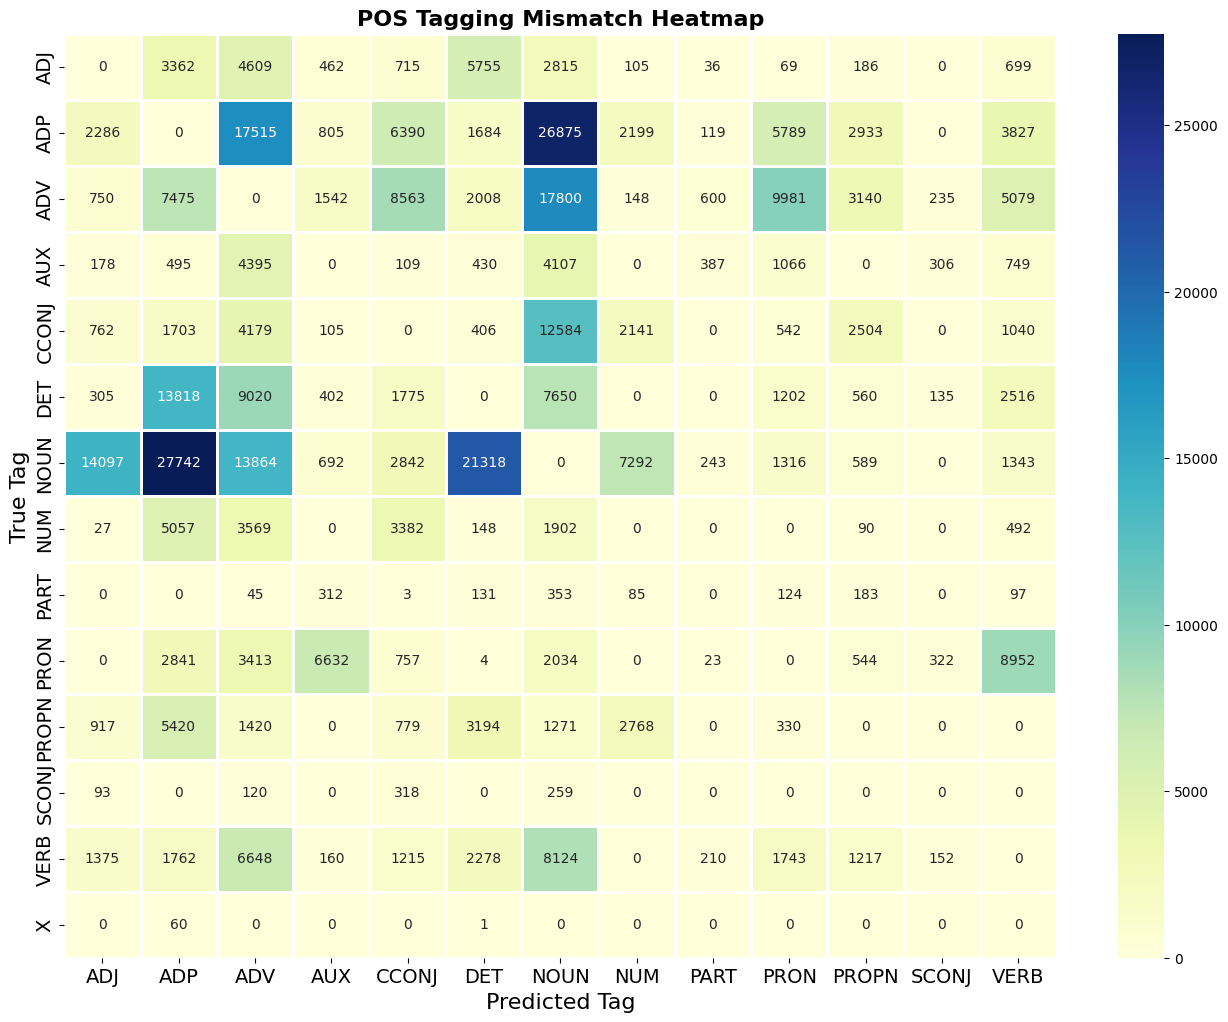

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

mismatch_data = [
    ('NOUN', 'ADJ', 14097), ('VERB', 'NOUN', 8124), ('ADP', 'VERB', 3827),
    ('DET', 'ADP', 13818), ('ADJ', 'DET', 5755), ('DET', 'NOUN', 7650),
    ('NOUN', 'DET', 21318), ('NOUN', 'ADP', 27742), ('ADV', 'NOUN', 17800),
    ('DET', 'VERB', 2516), ('ADP', 'NOUN', 26875), ('ADP', 'ADV', 17515),
    ('ADV', 'ADP', 7475), ('NOUN', 'PRON', 1316), ('ADP', 'DET', 1684),
    ('PRON', 'AUX', 6632), ('ADP', 'PRON', 5789), ('ADJ', 'NOUN', 2815),
    ('ADV', 'PROPN', 3140), ('NOUN', 'PROPN', 589), ('PRON', 'PROPN', 544),
    ('NOUN', 'CCONJ', 2842), ('AUX', 'PRON', 1066), ('ADV', 'AUX', 1542),
    ('CCONJ', 'NOUN', 12584), ('AUX', 'NOUN', 4107), ('ADJ', 'ADV', 4609),
    ('ADJ', 'AUX', 462), ('ADV', 'VERB', 5079), ('CCONJ', 'ADV', 4179),
    ('ADV', 'CCONJ', 8563), ('PROPN', 'ADP', 5420), ('PROPN', 'NUM', 2768),
    ('NOUN', 'ADV', 13864), ('CCONJ', 'PROPN', 2504), ('NUM', 'ADP', 5057),
    ('NOUN', 'NUM', 7292), ('NUM', 'CCONJ', 3382), ('PROPN', 'CCONJ', 779),
    ('PRON', 'VERB', 8952), ('PRON', 'ADP', 2841), ('VERB', 'PROPN', 1217),
    ('DET', 'SCONJ', 135), ('ADV', 'NUM', 148), ('ADP', 'PROPN', 2933),
    ('NOUN', 'VERB', 1343), ('DET', 'ADV', 9020), ('ADJ', 'ADP', 3362),
    ('PART', 'PRON', 124), ('CCONJ', 'ADP', 1703), ('DET', 'PRON', 1202),
    ('VERB', 'CCONJ', 1215), ('ADV', 'PRON', 9981), ('VERB', 'ADV', 6648),
    ('VERB', 'DET', 2278), ('PROPN', 'NOUN', 1271), ('ADV', 'DET', 2008),
    ('ADV', 'ADJ', 750), ('AUX', 'ADJ', 178), ('ADP', 'ADJ', 2286),
    ('VERB', 'ADJ', 1375), ('NUM', 'ADV', 3569), ('ADP', 'NUM', 2199),
    ('ADJ', 'PRON', 69), ('AUX', 'ADV', 4395), ('ADP', 'CCONJ', 6390),
    ('PROPN', 'ADV', 1420), ('DET', 'AUX', 402), ('VERB', 'PRON', 1743),
    ('AUX', 'ADP', 495), ('VERB', 'ADP', 1762), ('PRON', 'NOUN', 2034),
    ('NUM', 'NOUN', 1902), ('X', 'ADP', 60), ('NUM', 'VERB', 492),
    ('ADP', 'AUX', 805), ('PROPN', 'ADJ', 917), ('CCONJ', 'ADJ', 762),
    ('CCONJ', 'DET', 406), ('PRON', 'CCONJ', 757), ('PRON', 'ADV', 3413),
    ('PROPN', 'DET', 3194), ('NUM', 'PROPN', 90), ('ADP', 'PART', 119),
    ('DET', 'CCONJ', 1775), ('AUX', 'DET', 430), ('PART', 'AUX', 312),
    ('PART', 'DET', 131), ('PART', 'ADV', 45), ('ADV', 'PART', 600),
    ('CCONJ', 'AUX', 105), ('SCONJ', 'ADV', 120), ('SCONJ', 'NOUN', 259),
    ('NOUN', 'AUX', 692), ('CCONJ', 'NUM', 2141), ('X', 'DET', 1),
    ('AUX', 'CCONJ', 109), ('AUX', 'SCONJ', 306), ('SCONJ', 'CCONJ', 318),
    ('ADJ', 'CCONJ', 715), ('DET', 'ADJ', 305), ('ADJ', 'VERB', 699),
    ('VERB', 'PART', 210), ('PART', 'NOUN', 353), ('PROPN', 'PRON', 330),
    ('AUX', 'PART', 387), ('ADV', 'SCONJ', 235), ('AUX', 'VERB', 749),
    ('NUM', 'DET', 148), ('CCONJ', 'VERB', 1040), ('CCONJ', 'PRON', 542),
    ('PART', 'NUM', 85), ('DET', 'PROPN', 560), ('SCONJ', 'ADJ', 93),
    ('PART', 'VERB', 97), ('PRON', 'DET', 4), ('PRON', 'SCONJ', 322),
    ('NUM', 'ADJ', 27), ('PART', 'PROPN', 183), ('ADJ', 'PART', 36),
    ('VERB', 'SCONJ', 152), ('NOUN', 'PART', 243), ('PRON', 'PART', 23),
    ('ADJ', 'PROPN', 186), ('PART', 'CCONJ', 3), ('VERB', 'AUX', 160),
    ('ADJ', 'NUM', 105)
]

mismatch_counter = Counter({(true_tag, pred_tag): count for true_tag, pred_tag, count in mismatch_data})

mismatch_df = pd.DataFrame(list(mismatch_counter.items()), columns=['Tag Pair', 'Count'])
mismatch_df[['True Tag', 'Predicted Tag']] = pd.DataFrame(mismatch_df['Tag Pair'].tolist(), index=mismatch_df.index)

mismatch_df = mismatch_df.drop(columns=['Tag Pair'])

mismatch_matrix = mismatch_df.pivot_table(index="True Tag", columns="Predicted Tag", values="Count", fill_value=0)

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(mismatch_matrix, annot=True, fmt="g", cmap="YlGnBu", linewidths=1)
plt.title("POS Tagging Mismatch Heatmap", fontweight = 'bold', fontsize = 16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted Tag', fontsize=16)
plt.ylabel('True Tag', fontsize=16)

#plt.savefig('pos_tag_mismatch_heatmap.png',dpi =300, transparent=True)
plt.show()

**The code is to plot the bar chart for comparing POS tag distribution in both gen. and ref. sentences**

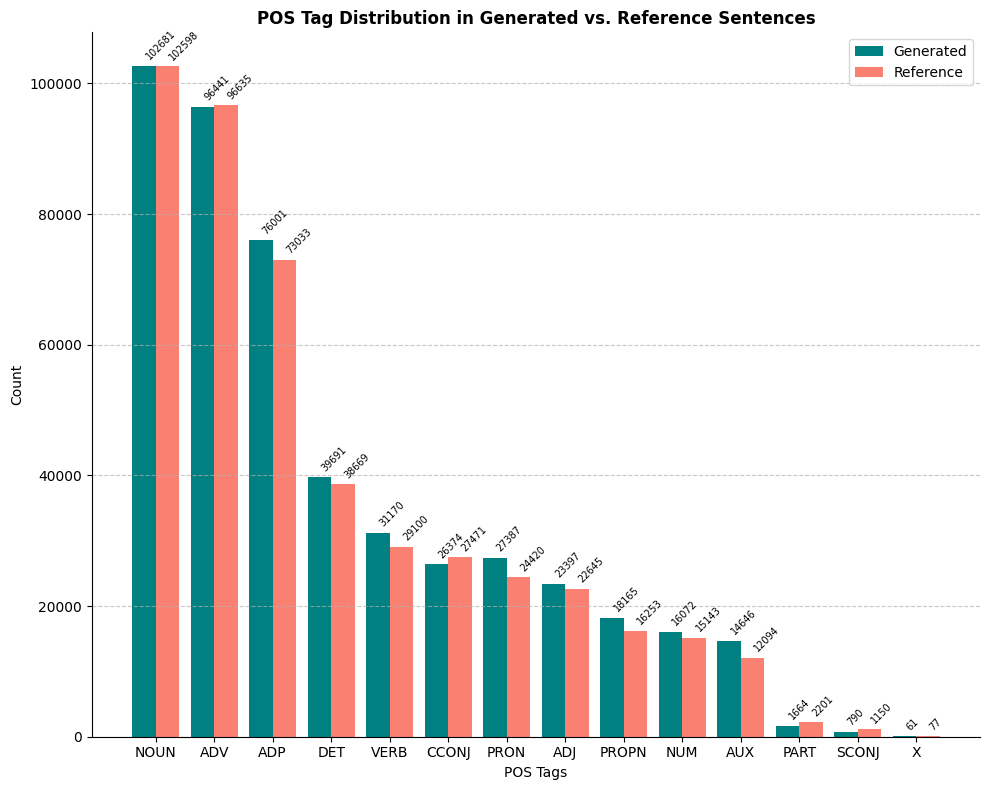

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

generated_pos_counts = {
    'NOUN': 102681, 'VERB': 31170, 'ADP': 76001, 'DET': 39691,
    'ADJ': 23397, 'ADV': 96441, 'PRON': 27387, 'AUX': 14646,
    'CCONJ': 26374, 'PROPN': 18165, 'NUM': 16072, 'PART': 1664,
    'X': 61, 'SCONJ': 790
}

reference_pos_counts = {
    'ADJ': 22645, 'NOUN': 102598, 'VERB': 29100, 'ADP': 73033,
    'DET': 38669, 'ADV': 96635, 'PRON': 24420, 'AUX': 12094,
    'PROPN': 16253, 'CCONJ': 27471, 'NUM': 15143, 'SCONJ': 1150,
    'PART': 2201, 'X': 77
}

pos_data = pd.DataFrame({
    'POS Tag': list(generated_pos_counts.keys()),
    'Generated': list(generated_pos_counts.values()),
    'Reference': [reference_pos_counts.get(tag, 0) for tag in generated_pos_counts.keys()]
})

# Sorting sum of dist for plotting
pos_data['Total'] = pos_data['Generated'] + pos_data['Reference']
pos_data = pos_data.sort_values(by='Total', ascending=False)

# Plot bar chart
x = np.arange(len(pos_data))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 8))

rects1 = ax.bar(x - width/2, pos_data['Generated'], width, label='Generated', color='teal')
rects2 = ax.bar(x + width/2, pos_data['Reference'], width, label='Reference', color='salmon')

ax.set_xlabel('POS Tags')
ax.set_ylabel('Count')
ax.set_title('POS Tag Distribution in Generated vs. Reference Sentences', fontweight = 'bold')
ax.set_xticks(x)
ax.set_xticklabels(pos_data['POS Tag'], ha="center")
ax.legend()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='left', va='bottom', fontsize=7, rotation =45)

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
fig.patch.set_alpha(0.0)

#plt.savefig('pos_tag_distribution.png',dpi =300, transparent=True)

plt.show()


**The code below is to check the dependensy parsing in the sentences**

In [ ]:
generated_sentences = extract_generated_sentences(model, dev_loader, device, vocab)

reference_json_path = '/content/drive/My Drive/proj/texts_dev.json'
with open(reference_json_path, 'r') as f:
    reference_sentences = json.load(f)

def syntax_tree_comparison(generated_sentences, reference_sentences):
    for i, (gen_sentence, ref_sentence) in enumerate(zip(generated_sentences, reference_sentences)):
        gen_doc = nlp(gen_sentence)
        ref_doc = nlp(ref_sentence)

        print(f"\n--- Sentence {i+1} Syntax Tree Comparison ---")
        print("Generated Sentence Syntax Tree:")
        for token in gen_doc:
            print(f"{token.text} -> {token.dep_} ({token.head.text})")

        print("\nReference Sentence Syntax Tree:")
        for token in ref_doc:
            print(f"{token.text} -> {token.dep_} ({token.head.text})")

syntax_tree_comparison(generated_sentences, reference_sentences)


Streaming output truncated to the last 5000 lines.
klar -> mo (trocken)
meist -> mo (trocken)
trocken -> cj (und)
und -> cd (fällt)
bleibt -> cj (und)
heute -> mo (bleibt)
teil -> pd (bleibt)
noch -> mo (bleibt)
regen -> pd (bleibt)

Reference Sentence Syntax Tree:
im -> mo (bleibt)
osten -> nk (im)
und -> cd (osten)
süden -> cj (und)
bleibt -> ROOT (bleibt)
es -> ep (bleibt)
heute -> mo (bleibt)
nacht -> mo (bleibt)
meist -> mo (trocken)
trocken -> mo (bleibt)
und -> cd (trocken)
teilweise -> mo (klar)
auch -> mo (klar)
noch -> mo (klar)
klar -> cj (und)
sonst -> mo (fällt)
fällt -> cj (bleibt)
zum -> mo (fällt)
teil -> nk (zum)
schauerartiger -> nk (regen)
regen -> ag (teil)

--- Sentence 31124 Syntax Tree Comparison ---
Generated Sentence Syntax Tree:
osten -> sb (fällt)
und -> cd (osten)
meist -> mo (bleibt)
bleibt -> cj (und)
es -> ep (bleibt)
heute -> mo (bleibt)
nacht -> mo (bleibt)
fällt -> ROOT (fällt)
klar -> mo (fällt)
und -> cd (klar)
meist -> mo (trocken)
klar -> mo (trock

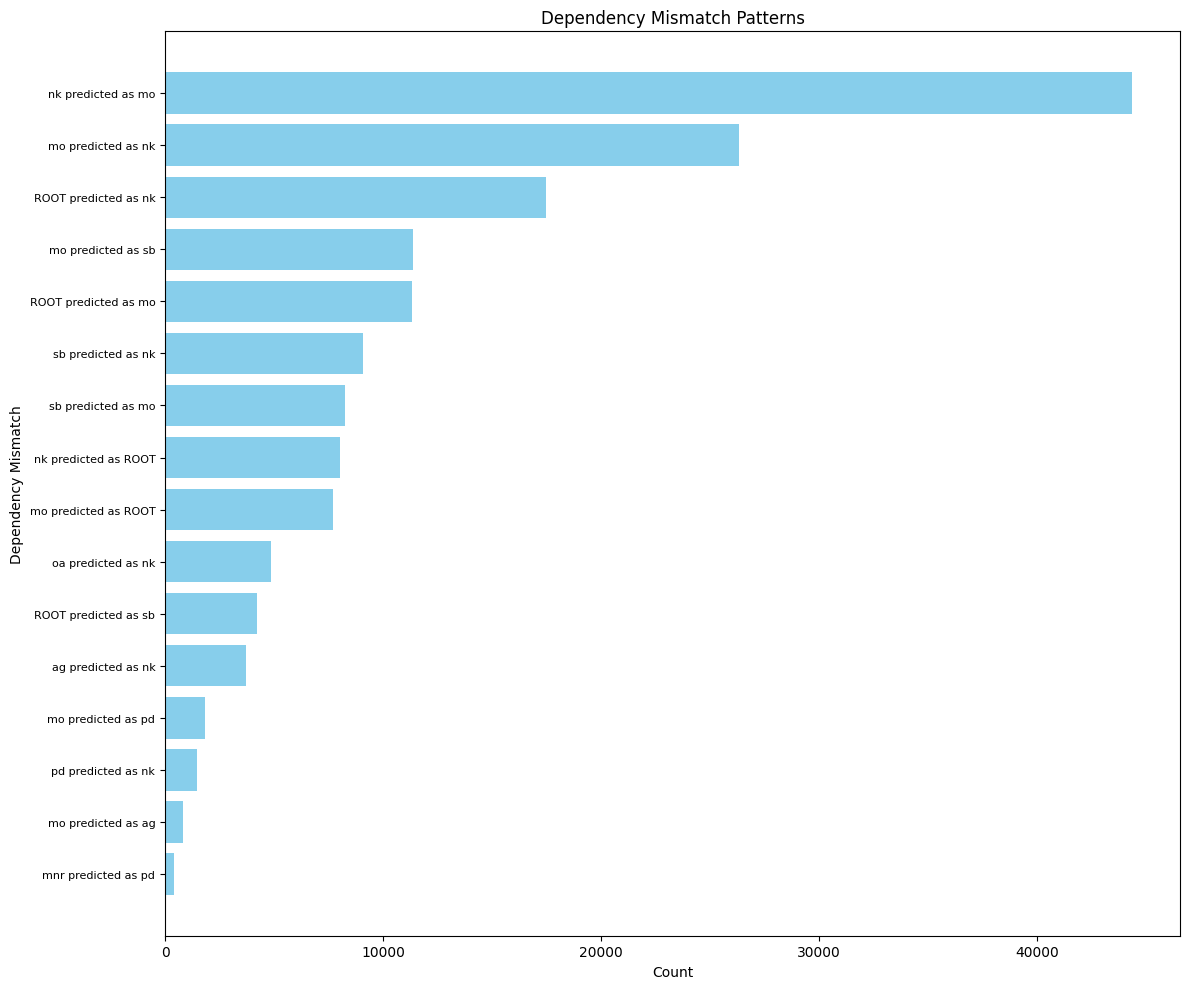

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# list of dependency mismatch patterns and their counts
mismatch_data = [
    ('sb', 'nk', 9066), ('ROOT', 'sb', 4223), ('mo', 'ROOT', 7694), ('nk', 'mo', 44351),
    ('oa', 'nk', 4880), ('ROOT', 'mo', 11311), ('pd', 'nk', 1462), ('nk', 'ROOT', 8050),
    ('mo', 'sb', 11382), ('sb', 'mo', 8259), ('ROOT', 'nk', 17461), ('ag', 'nk', 3701),
    ('mo', 'nk', 26322), ('mo', 'pd', 1856), ('mnr', 'pd', 404), ('mo', 'ag', 819),

]

# convert df
mismatch_df = pd.DataFrame(mismatch_data, columns=['Generated Dependency', 'Reference Dependency', 'Count'])

# Sorting
mismatch_df = mismatch_df.sort_values(by='Count', ascending=True)


plt.figure(figsize=(12, 10))

plt.barh(mismatch_df['Generated Dependency'] + " predicted as " + mismatch_df['Reference Dependency'], mismatch_df['Count'], color='skyblue')

plt.yticks(fontsize=8)
plt.xlabel('Count')
plt.ylabel('Dependency Mismatch')
plt.title('Dependency Mismatch Patterns')

plt.tight_layout()

plt.show()


**The code below is to train model idea 1: adjusted loss function with POS tag based weight**

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


TransformerModel(
  (embedding): Linear(in_features=256, out_features=128, bias=True)
  (target_embedding): Embedding(1987, 128)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.3, inplace=False)
          (dropout2): Dropout(p=0.3, inplace=False)
        )
      )
      (norm): LayerN

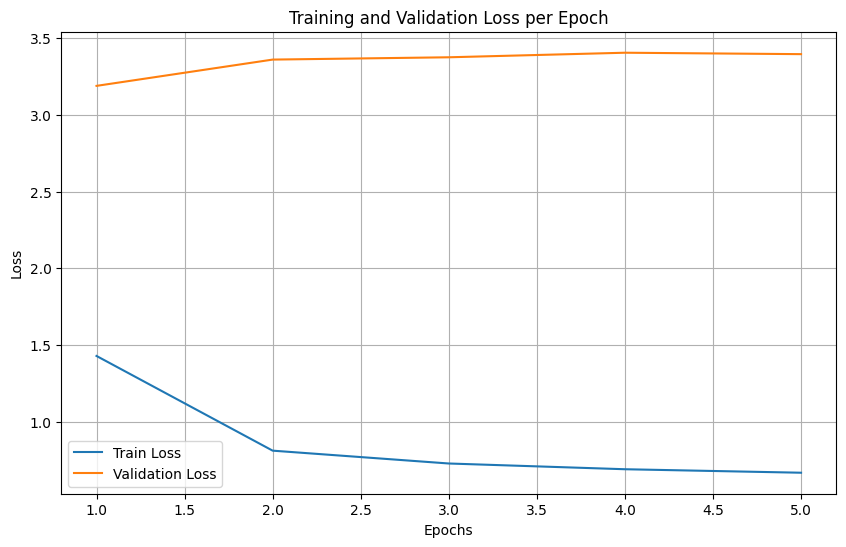

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.metrics import edit_distance
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import spacy
from collections import Counter
import math
import torch.optim as optim
import time
import matplotlib.pyplot as plt

nltk.download('punkt')

nlp = spacy.load("de_core_news_sm")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

# Func to build a word vocab
def build_vocab(texts):
    words = set()
    for text in texts:
        words.update(text.split())
    vocab = {word: idx for idx, word in enumerate(sorted(words))}
    vocab['<pad>'] = len(vocab)
    return vocab


train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')

# Initialize ref POS tag counts
reference_pos_counts = {
    'NOUN': 2055198, 'VERB': 669940, 'ADP': 1417884, 'DET': 826086,
    'ADJ': 474210, 'ADV': 2006124, 'PRON': 522098, 'AUX': 253906,
    'CCONJ': 515384, 'PROPN': 266386, 'NUM': 183686, 'PART': 31000,
    'X': 1192, 'SCONJ': 25360
}

# convert POS counts to frequencies
total_count = sum(reference_pos_counts.values())
reference_pos_frequencies = {tag: count / total_count for tag, count in reference_pos_counts.items()}

dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')
test_sequences, test_texts = load_full_data('/content/drive/My Drive/proj/sequences_test.npy', '/content/drive/My Drive/proj/texts_test.json')

vocab = build_vocab(train_texts)
pad_idx = vocab['<pad>']

INPUT_DIM = 256 #1024
EMBED_DIM = 128 #512
NUM_HEADS = 4
NUM_LAYERS = 1
OUTPUT_DIM = len(vocab)
BATCH_SIZE = 64

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.3, # original 0.1
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(0.3) # 0.1
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(self.dropout(src)))
        tgt = self.positional_encoding(self.layer_norm(self.dropout(tgt)))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long)
        return sequence, text_tokens

def word_tokenizer(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

def decode_text(output, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    decoded_texts = []
    for seq in output:
        decoded_text = ' '.join([inv_vocab[token] for token in seq if token in inv_vocab and inv_vocab[token] != '<pad>'])
        decoded_texts.append(decoded_text)
    return decoded_texts

# Custom loss function with POS tag weighting
class POSWeightedCrossEntropyLoss(nn.Module):
    def __init__(self, criterion, pos_frequencies, total_count, vocab, pad_idx):
        super(POSWeightedCrossEntropyLoss, self).__init__()
        self.criterion = criterion
        self.pos_frequencies = pos_frequencies
        self.total_count = total_count
        self.vocab = vocab
        self.pad_idx = pad_idx

    def forward(self, outputs, targets):
        loss = self.criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))

        for pos_tag, frequency in self.pos_frequencies.items():
            if pos_tag in self.vocab:
                pos_idx = self.vocab[pos_tag]
                mask = (targets == pos_idx).float()
                pos_weight = (self.total_count / frequency) / mask.sum()
                loss += (mask * loss * pos_weight).sum()

        return loss

def evaluate_and_metrics(model, loader, device, vocab, pad_idx):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    correct_predictions = 0
    total_predictions = 0
    all_predicted_tokens = []
    all_target_tokens = []
    sequence_matches = 0
    total_sequences = 0
    total_edit_distance = 0
    references = []
    hypotheses = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])
            loss = criterion(outputs.view(-1, outputs.size(-1)), texts[:, 1:].reshape(-1))
            total_loss += loss.item()

            predicted_tokens = outputs.argmax(dim=-1)
            all_predicted_tokens.extend(predicted_tokens.cpu().numpy().flatten())
            all_target_tokens.extend(texts[:, 1:].cpu().numpy().flatten())

            correct_predictions += (predicted_tokens == texts[:, 1:]).sum().item()
            total_predictions += texts[:, 1:].ne(pad_idx).sum().item()

            for pred_seq, tgt_seq in zip(predicted_tokens.cpu().numpy(), texts[:, 1:].cpu().numpy()):
                total_sequences += 1
                if np.array_equal(pred_seq, tgt_seq):
                    sequence_matches += 1
                total_edit_distance += edit_distance(pred_seq.tolist(), tgt_seq.tolist())

                references.append(decode_text([tgt_seq], vocab))
                hypotheses.append(decode_text([pred_seq], vocab))

    avg_loss = total_loss / len(loader)
    token_accuracy = correct_predictions / total_predictions
    sequence_accuracy = sequence_matches / total_sequences
    avg_edit_distance = total_edit_distance / total_sequences

    precision = precision_score(all_target_tokens, all_predicted_tokens, average='macro', zero_division=0)
    recall = recall_score(all_target_tokens, all_predicted_tokens, average='macro', zero_division=0)
    f1 = f1_score(all_target_tokens, all_predicted_tokens, average='macro', zero_division=0)

    # BLEU scores calc
    smoothing = SmoothingFunction().method4
    bleu_scores = { "BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": [] }
    for ref, hyp in zip(references, hypotheses):
        ref_tokens = nltk.word_tokenize(ref[0])
        hyp_tokens = nltk.word_tokenize(hyp[0])
        bleu_scores["BLEU-1"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-2"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-3"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-4"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

    avg_bleu_scores = { key: np.mean(value) for key, value in bleu_scores.items() }

    # ROUGE scores calc
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = { "ROUGE-1": [], "ROUGE-2": [], "ROUGE-L": [] }
    for ref, hyp in zip(references, hypotheses):
        score = rouge_scorer_inst.score(ref[0], hyp[0])
        rouge_scores["ROUGE-1"].append(score['rouge1'].fmeasure)
        rouge_scores["ROUGE-2"].append(score['rouge2'].fmeasure)
        rouge_scores["ROUGE-L"].append(score['rougeL'].fmeasure)

    avg_rouge_scores = { key: np.mean(value) for key, value in rouge_scores.items() }

    return {
        'avg_loss': avg_loss,
        'token_accuracy': token_accuracy,
        'sequence_accuracy': sequence_accuracy,
        'avg_edit_distance': avg_edit_distance,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'bleu_scores': avg_bleu_scores,
        'rouge_scores': avg_rouge_scores
    }

train_dataset = LandmarksDataset(train_sequences, train_texts, lambda text: word_tokenizer(text, vocab))
dev_dataset = LandmarksDataset(dev_sequences, dev_texts, lambda text: word_tokenizer(text, vocab))
test_dataset = LandmarksDataset(test_sequences, test_texts, lambda text: word_tokenizer(text, vocab))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)


model = TransformerModel(INPUT_DIM, EMBED_DIM, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM).to(device)
model.train()

# Print model summary
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

# Initialize the POS weighted loss criterion
criterion = POSWeightedCrossEntropyLoss(
    criterion=nn.CrossEntropyLoss(ignore_index=pad_idx),
    pos_frequencies=reference_pos_counts,
    total_count=sum(reference_pos_counts.values()),
    vocab=vocab,
    pad_idx=pad_idx
)

# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#Implement L2 regularization by adjusting the optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

train_losses = []
val_losses = []

# Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for sequences, texts in train_loader:
        sequences, texts = sequences.to(device), texts.to(device)
        optimizer.zero_grad()
        outputs = model(sequences, texts[:, :-1])
        loss = criterion(outputs, texts[:, 1:])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    val_metrics = evaluate_and_metrics(model, dev_loader, device, vocab, pad_idx)
    epoch_time = time.time() - start_time

    train_losses.append(avg_epoch_loss)
    val_losses.append(val_metrics["avg_loss"])

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_metrics["avg_loss"]:.4f}, Epoch Time: {epoch_time:.2f}s')

test_metrics = evaluate_and_metrics(model, test_loader, device, vocab, pad_idx)
print(f"\nTest Metrics:")
print(f"Test Loss: {test_metrics['avg_loss']:.4f}")
print(f"Test Token Accuracy: {test_metrics['token_accuracy']:.4f}")
print(f"Test Sequence Accuracy: {test_metrics['sequence_accuracy']:.4f}")
print(f"Test Avg Edit Distance: {test_metrics['avg_edit_distance']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")
for key, value in test_metrics['bleu_scores'].items():
    print(f"Average Test {key}: {value:.4f}")
for key, value in test_metrics['rouge_scores'].items():
    print(f"Average Test {key}: {value:.4f}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

torch.save(model.state_dict(), '/content/drive/My Drive/proj/fine_tuned_transformer.pth')


**The code below is for checking the overview of the train set: datasize, seq length, vocab size, common glosses**

Total Number of Sign Sequences: 580732
Total Number of Gloss Annotations: 9248454
Vocabulary Size (Total Unique Glosses): 1986
Most Common Glosses:
und: 388440
im: 273238
es: 247376
der: 234624
in: 200904
am: 196310
die: 174590
auch: 166426
den: 135336
bis: 133568
grad: 129378
morgen: 114002
nacht: 96764
regen: 87822
noch: 86036
an: 84058
wolken: 78962
sich: 78300
heute: 77110
sonne: 70996


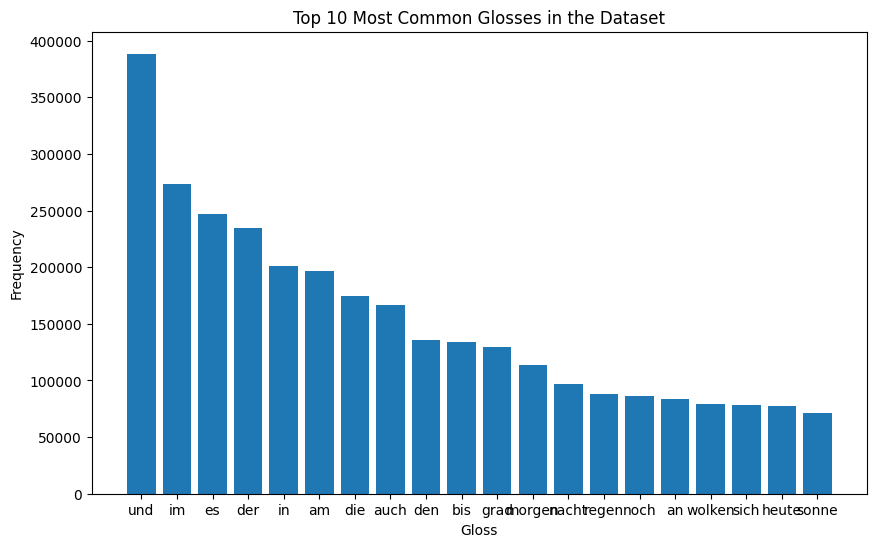

Minimum Sequence Length: 2
Maximum Sequence Length: 44
Average Sequence Length: 15.93
Median Sequence Length: 15.0


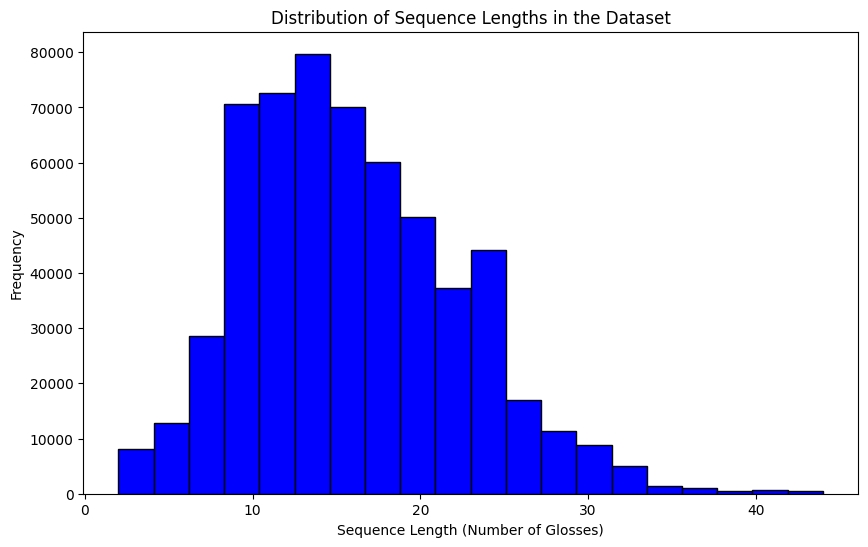

In [ ]:
import numpy as np
import json
from collections import Counter
import matplotlib.pyplot as plt

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')

# 1. Dataset Size
total_sequences = len(train_sequences)
total_gloss_annotations = sum(len(text.split()) for text in train_texts)

print(f"Total Number of Sign Sequences: {total_sequences}")
print(f"Total Number of Gloss Annotations: {total_gloss_annotations}")

# 2. Vocabulary Size
glosses = [gloss for text in train_texts for gloss in text.split()]
unique_glosses = set(glosses)
vocabulary_size = len(unique_glosses)

print(f"Vocabulary Size (Total Unique Glosses): {vocabulary_size}")

gloss_frequency = Counter(glosses)

# 3. Most Common Glosses
most_common_glosses = gloss_frequency.most_common(20)
print("Most Common Glosses:")
for gloss, freq in most_common_glosses:
    print(f"{gloss}: {freq}")

plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_glosses))
plt.xlabel('Gloss')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Glosses in the Dataset')
plt.show()

# 4. Sequence Length Analysis
sequence_lengths = [len(text.split()) for text in train_texts]

min_len = np.min(sequence_lengths)
max_len = np.max(sequence_lengths)
avg_len = np.mean(sequence_lengths)
median_len = np.median(sequence_lengths)

print(f"Minimum Sequence Length: {min_len}")
print(f"Maximum Sequence Length: {max_len}")
print(f"Average Sequence Length: {avg_len:.2f}")
print(f"Median Sequence Length: {median_len}")

plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='blue', edgecolor='black')
plt.xlabel('Sequence Length (Number of Glosses)')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in the Dataset')
plt.show()


**The code below is to plot bar chart for top 20 most common glosses in train set**

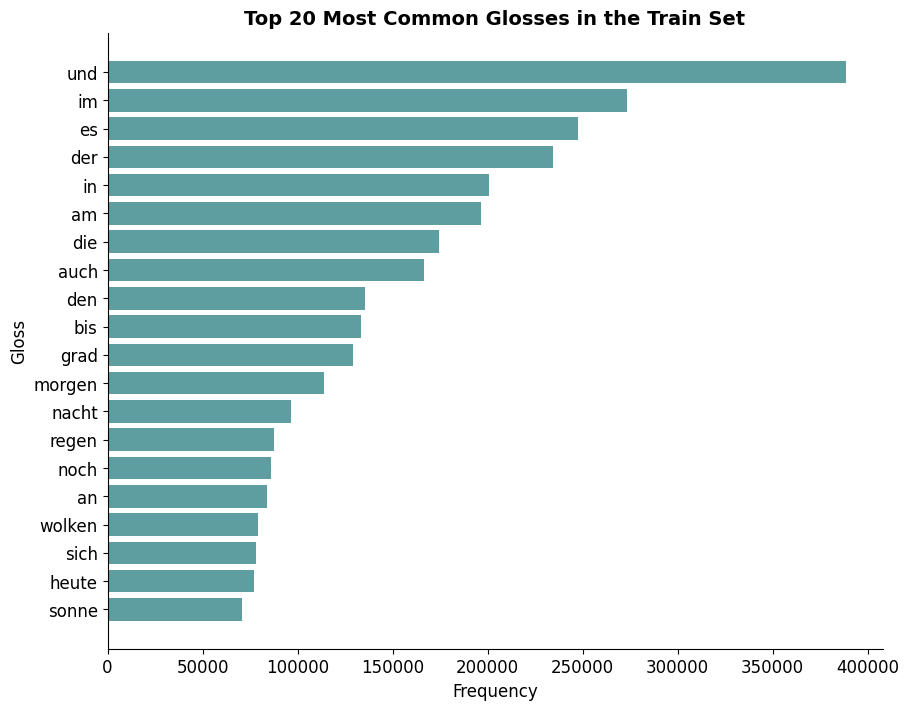

In [ ]:
gloss_labels, gloss_counts = zip(*most_common_glosses)
gloss_labels = list(gloss_labels)[::-1]
gloss_counts = list(gloss_counts)[::-1]

plt.figure(figsize=(10, 8))
plt.barh(gloss_labels, gloss_counts, color='cadetblue')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Gloss', fontsize = 12)
plt.title('Top 20 Most Common Glosses in the Train Set', fontsize =14, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('trainset_top20gloss.png',dpi =300, transparent=True)

plt.show()

**The code below is to plot dist of sequence lengths**

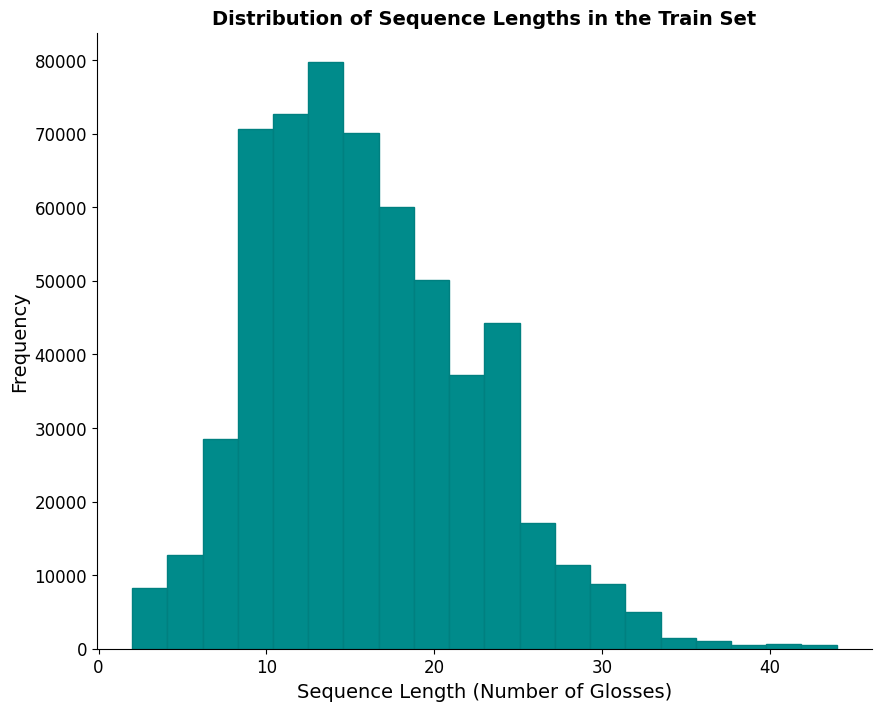

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.hist(sequence_lengths, bins=20, color='darkcyan', edgecolor='teal')

plt.xlabel('Sequence Length (Number of Glosses)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Sequence Lengths in the Train Set', fontsize=14, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('trainset_DistofSeqLength.png',dpi =300, transparent=True)

plt.show()


**The code below is to count POS tags, morph features in the train set**

In [ ]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

nlp = spacy.load('de_core_news_sm')

#gloss_annotations = train_texts

# Load the train dataset
train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')
gloss_annotations = train_texts

# POS Tagging and Morph features Analysis
pos_tags = []
morph_features = []

for gloss in gloss_annotations:
    doc = nlp(gloss)
    for token in doc:
        pos_tags.append(token.pos_)
        morph_features.append(token.morph)

# for POS tag dist
pos_tag_counts = Counter(pos_tags)

# for morph features dist
morph_feature_counts = Counter()

for morph in morph_features:
    for feature in morph:
        morph_feature_counts[feature] += 1



**The code below is to plot bar chart for POS tag dist. in the train set**

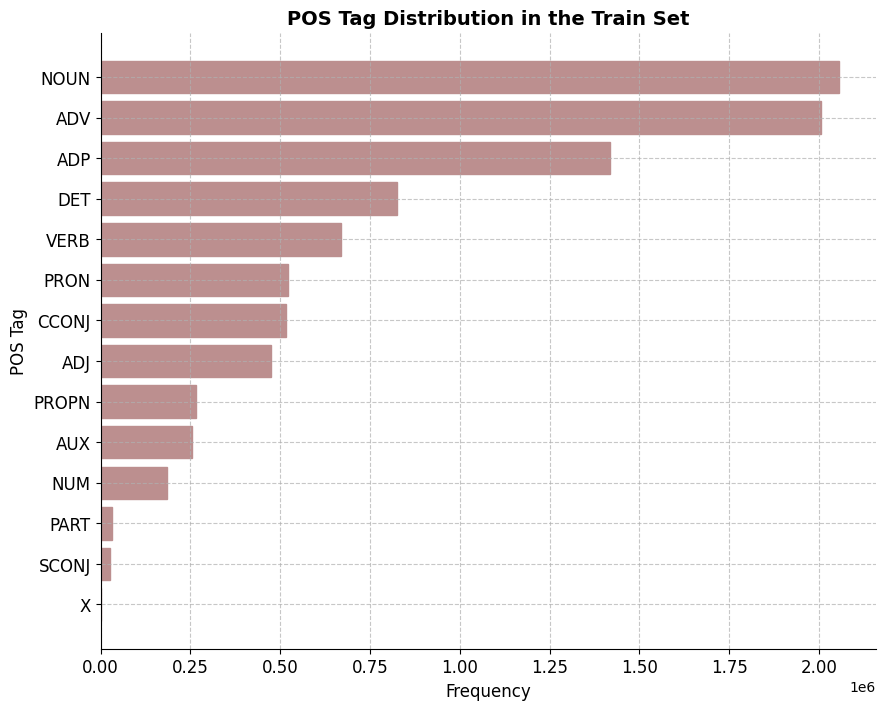

In [ ]:
from matplotlib.ticker import FuncFormatter

sorted_pos_counts = dict(sorted(pos_tag_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 8))
plt.barh(list(sorted_pos_counts.keys()), list(sorted_pos_counts.values()), color='rosybrown', edgecolor='rosybrown')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('POS Tag', fontsize=12)
plt.title('POS Tag Distribution in the Train Set', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.savefig('trainset_POStagDist.png',dpi =300, transparent=True) #to save fig
plt.show()

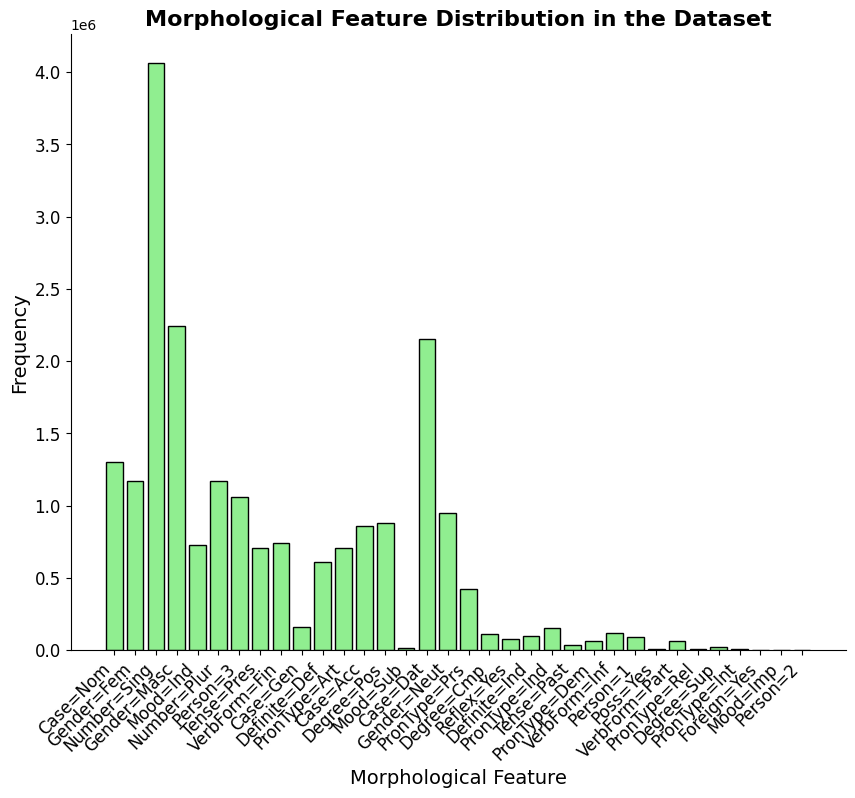

In [ ]:
# Plot Morphological Feature Distribution
plt.figure(figsize=(10, 8))
plt.bar(morph_feature_counts.keys(), morph_feature_counts.values(), color='lightgreen', edgecolor='black')
plt.title('Morphological Feature Distribution in the Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Morphological Feature', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()




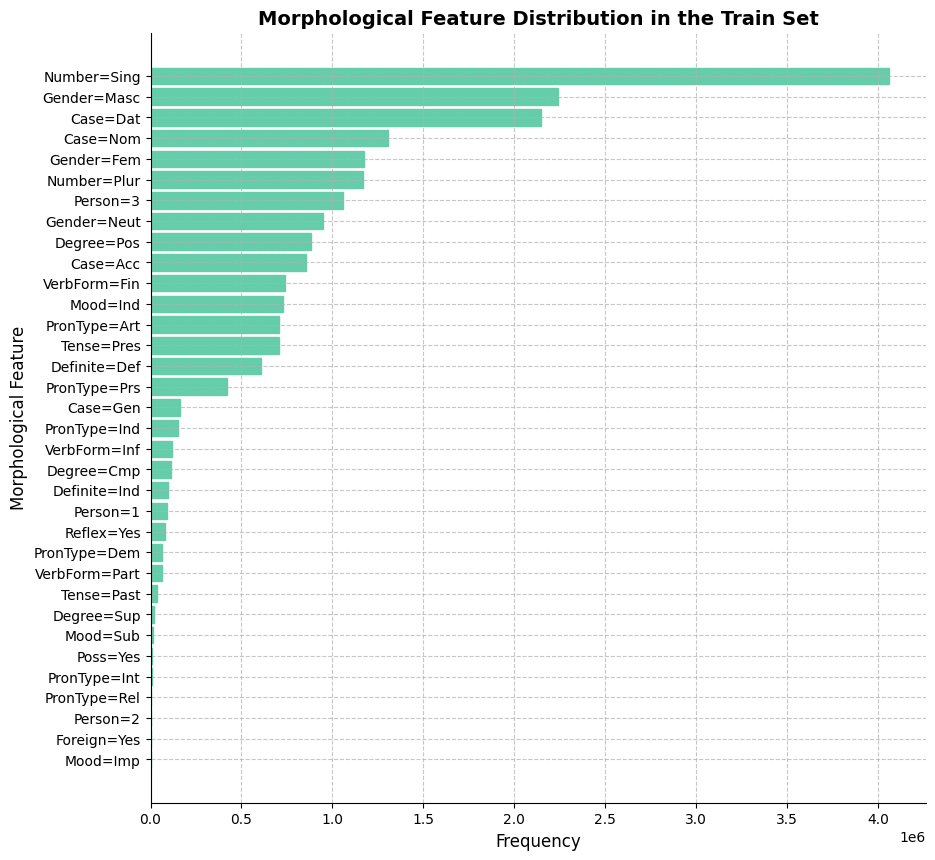

In [ ]:
import matplotlib.pyplot as plt


sorted_morph_freq = dict(sorted(morph_feature_counts.items(), key=lambda item: item[1], reverse=False))

plt.figure(figsize=(10, 10))
plt.barh(list(sorted_morph_freq.keys()), list(sorted_morph_freq.values()), color='mediumaquamarine', edgecolor='mediumaquamarine')
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Morphological Feature', fontsize=12)
plt.title('Morphological Feature Distribution in the Train Set', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.savefig('trainset_MorphFeatureDist.png',dpi =300, transparent=True)
plt.show()


**The code below is to print out the morph features and their frequency**

In [ ]:
print(morph_feature_counts)

Counter({'Number=Sing': 4059324, 'Gender=Masc': 2239776, 'Case=Dat': 2149620, 'Case=Nom': 1304362, 'Gender=Fem': 1172676, 'Number=Plur': 1169754, 'Person=3': 1060500, 'Gender=Neut': 948892, 'Degree=Pos': 880456, 'Case=Acc': 855986, 'VerbForm=Fin': 741994, 'Mood=Ind': 728290, 'PronType=Art': 706116, 'Tense=Pres': 704190, 'Definite=Def': 609256, 'PronType=Prs': 420538, 'Case=Gen': 163136, 'PronType=Ind': 153504, 'VerbForm=Inf': 119940, 'Degree=Cmp': 109990, 'Definite=Ind': 96860, 'Person=1': 90490, 'Reflex=Yes': 80230, 'PronType=Dem': 62138, 'VerbForm=Part': 61006, 'Tense=Past': 37804, 'Degree=Sup': 18838, 'Mood=Sub': 13704, 'Poss=Yes': 10790, 'PronType=Int': 6426, 'PronType=Rel': 4778, 'Person=2': 1658, 'Foreign=Yes': 964, 'Mood=Imp': 906})


**The code below is to plot the wordcloud for top 20 morph features**

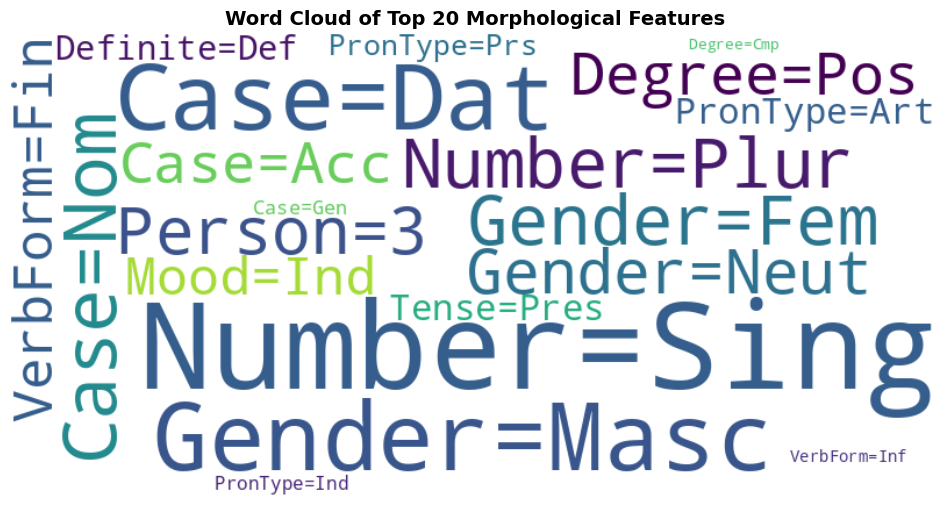

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming `morph_feature_counts` contains the morphological features and their frequencies

# Sort the morphological features by frequency
sorted_morph_freq = dict(sorted(morph_feature_counts.items(), key=lambda item: item[1], reverse=True))

# Select the top 20 most frequent morphological features
top_20_morph_freq = dict(list(sorted_morph_freq.items())[:20])

# Create a word cloud from the top 20 features
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_20_morph_freq)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 20 Morphological Features', fontsize=14, fontweight='bold')

plt.savefig('trainset_MorphFeatureDistTreeMap.png',dpi =300, transparent=True)
plt.show()


**The code below is to extract denpendency parsing, and syntactic structures from train set**

In [ ]:
import spacy
from collections import Counter
import numpy as np
import json

nlp = spacy.load("de_core_news_sm")

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts


train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')

def analyze_syntactic_structure(texts):
    structure_patterns = Counter()
    dependency_relations = Counter()

    for text in texts:
        doc = nlp(text)
        # extract syntactic structures
        pos_tags = [token.pos_ for token in doc]
        structure_patterns.update(["-".join(pos_tags)])

        # extract deependency
        for token in doc:
            if token.dep_ != 'punct':
                dependency_relations.update([(token.dep_, token.head.pos_, token.pos_)])

    return structure_patterns, dependency_relations

structure_patterns, dependency_relations = analyze_syntactic_structure(train_texts)

print("Most Common Sentence Structures:")
for pattern, count in structure_patterns.most_common(10):
    print(f'{pattern}: {count}')

print("\nMost Common Dependency Relations:")
for relation, count in dependency_relations.most_common(10):
    print(f'{relation}: {count}')


Most Common Sentence Structures:
CCONJ-ADV-DET-NOUN-ADP-ADV-NOUN-DET-ADJ-NOUN: 21626
CCONJ-ADV-DET-NOUN-ADP-ADV-ADV-DET-ADJ-NOUN: 4590
ADJ-NOUN-VERB-NOUN: 1996
ADJ-NOUN-ADJ-NOUN: 1840
PRON-DET-ADJ-NOUN-CCONJ-VERB-PRON-PRON-ADV: 1252
PRON-VERB-ADJ-NOUN-DET-ADJ-NOUN: 1002
ADJ-NOUN-VERB-PRON-ADV-NOUN-CCONJ-ADV-ADP-NOUN-ADJ-NOUN-DET-PRON-ADP-DET-NOUN-PROPN-ADV-ADP-NOUN-VERB: 816
ADP-DET-NOUN-ADV-ADV-ADV-ADV-ADP-ADJ-NOUN-ADV-ADJ-ADV: 780
ADP-NOUN-VERB-PRON-ADV-ADV-CCONJ-ADV-ADV-DET-NOUN-VERB-DET-NOUN-ADV-PART-ADV-SCONJ-PRON-ADP-PRON-ADP-NOUN-CCONJ-NOUN-ADV-ADV-ADJ-NOUN-VERB-ADP-PRON-PRON-ADJ-NOUN-CCONJ-ADV-VERB-AUX-ADP-NOUN: 708
DET-NOUN-VERB-ADV-DET-NOUN-PROPN-ADV-ADV-ADJ-NOUN-ADP-ADJ-NOUN-ADP-ADJ-NOUN-VERB-DET-ADV-ADP-DET-ADJ-NOUN-DET-NOUN-VERB: 646

Most Common Dependency Relations:
('nk', 'ADP', 'NOUN'): 1051880
('mo', 'VERB', 'ADV'): 673636
('nk', 'NOUN', 'DET'): 666412
('mo', 'VERB', 'ADP'): 555684
('nk', 'NOUN', 'ADJ'): 412200
('ROOT', 'VERB', 'VERB'): 308946
('mo', 'ADV', 'ADV'): 28

**The code below is to print out the ref texts from train set**

In [ ]:
import pprint
pp = pprint.PrettyPrinter(width=80)

pp.pprint(train_texts[:1000])

['trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenheit und frost setzen der landwirtschaft zu',
 'trockenh

**The code below is to extract top 50 bigrams/trigrams from dev set**

In [ ]:
import nltk
import spacy
from collections import Counter
import numpy as np
import json

nltk.download('punkt')
nlp = spacy.load("de_core_news_sm")

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

# Load the train dataset
dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')


gloss_sequences = [gloss.split() for gloss in dev_texts]

bigrams = []
for sequence in gloss_sequences:
    bigrams.extend(list(nltk.bigrams(sequence)))


bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(50)
print('Most Common Bigram Transitions:')
for bigram, count in most_common_bigrams:
    print(f'{bigram}: {count}')

trigrams = []
for sequence in gloss_sequences:
    trigrams.extend(list(nltk.trigrams(sequence)))

trigram_counts = Counter(trigrams)

most_common_trigrams = trigram_counts.most_common(50)
print('\nMost Common Trigram Sequences:')
for trigram, count in most_common_trigrams:
    print(f'{trigram}: {count}')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Most Common Bigram Transitions:
('in', 'der'): 3879
('heute', 'nacht'): 3723
('im', 'norden'): 3109
('im', 'süden'): 2990
('am', 'tag'): 2371
('wettervorhersage', 'für'): 2287
('für', 'morgen'): 2287
('und', 'nun'): 2195
('nun', 'die'): 2195
('die', 'wettervorhersage'): 2195
('an', 'den'): 2050
('an', 'der'): 1978
('in', 'den'): 1843
('grad', 'am'): 1823
('bleibt', 'es'): 1817
('grad', 'im'): 1786
('wird', 'es'): 1650
('ist', 'es'): 1630
('zum', 'teil'): 1575
('im', 'westen'): 1570
('und', 'da'): 1553
('hier', 'und'): 1264
('den', 'küsten'): 1215
('ein', 'paar'): 1189
('gibt', 'es'): 1178
('grad', 'an'): 1105
('schauer', 'und'): 1087
('am', 'oberrhein'): 1085
('den', 'alpen'): 1081
('im', 'südosten'): 1050
('und', 'es'): 1048
('grad', 'in'): 1023
('im', 'osten'): 967
('norden', 'und'): 961
('im', 'nordosten'): 957
('vor', 'allem'): 951
('der', 'nordsee'): 908
('im', 'südwesten'): 900
('auch', 'im'): 897
('der', 'mitte'): 873
('die', 'sonne'): 854
('dreizehn', 'grad'): 844
('drei', 'gra

**The code below is for training model of idea 2: subword tokenisation**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import sentencepiece as spm
import time
import math
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')

with open('train_texts.txt', 'w') as f:
    for sentence in train_texts:
        f.write(sentence + '\n')

# Train a SentencePiece model
spm.SentencePieceTrainer.train(
    input='train_texts.txt',  # Replace with your actual input file path
    model_prefix='spm',
    vocab_size=1200,
    model_type='bpe',
    max_sentence_length=2048,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
    user_defined_symbols=['<sep>', '<cls>']
)


sp = spm.SentencePieceProcessor(model_file='spm.model')
vocab_size = len(sp)

def sp_tokenizer(text):
    return sp.encode(text, out_type=int)


class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32).to(device)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long).to(device)
        return sequence, text_tokens


def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded


train_dataset = LandmarksDataset(train_sequences, train_texts, sp_tokenizer)
dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')
dev_dataset = LandmarksDataset(dev_sequences, dev_texts, sp_tokenizer)
test_sequences, test_texts = load_full_data('/content/drive/My Drive/proj/sequences_test.npy', '/content/drive/My Drive/proj/texts_test.json')
test_dataset = LandmarksDataset(test_sequences, test_texts, sp_tokenizer)

BATCH_SIZE = 32  # Reduced batch size for faster testing
INPUT_DIM = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: collate_fn(x, pad_idx=0, input_dim=INPUT_DIM), num_workers=0, pin_memory=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx=0, input_dim=INPUT_DIM), num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx=0, input_dim=INPUT_DIM), num_workers=0, pin_memory=False)

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.2)  # Increased dropout
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.2,  # Increased dropout
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(src))
        tgt = self.positional_encoding(self.layer_norm(tgt))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

def evaluate_and_metrics(model, loader, device, pad_idx, sp, calculate_bleu=True):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])
            loss = criterion(outputs.view(-1, outputs.size(-1)), texts[:, 1:].reshape(-1))
            total_loss += loss.item()

            if calculate_bleu:

                preds = outputs.argmax(dim=-1).cpu().numpy()
                all_predictions.extend(preds)
                all_targets.extend(texts[:, 1:].cpu().numpy())

    avg_loss = total_loss / len(loader)

    metrics = {
        'avg_loss': avg_loss,
    }

    if calculate_bleu:
        # BLEU score calc
        smoothing = SmoothingFunction().method4
        bleu_scores = { "BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": [] }
        for target_seq, pred_seq in zip(all_targets, all_predictions):
            target_text = sp.decode_ids([int(t) for t in target_seq if t != pad_idx])
            pred_text = sp.decode_ids([int(p) for p in pred_seq if p != pad_idx])
            ref_tokens = nltk.word_tokenize(target_text)
            hyp_tokens = nltk.word_tokenize(pred_text)
            bleu_scores["BLEU-1"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing))
            bleu_scores["BLEU-2"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
            bleu_scores["BLEU-3"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
            bleu_scores["BLEU-4"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

        avg_bleu_scores = { key: np.mean(value) for key, value in bleu_scores.items() }
        metrics.update(avg_bleu_scores)

    return metrics


model = TransformerModel(INPUT_DIM, 512, 4, 1, vocab_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for sequences, texts in train_loader:
        sequences, texts = sequences.to(device), texts.to(device)
        optimizer.zero_grad()
        outputs = model(sequences, texts[:, :-1])
        loss = criterion(outputs.view(-1, outputs.size(-1)), texts[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    val_metrics = evaluate_and_metrics(model, dev_loader, device, pad_idx=0, sp=sp, calculate_bleu=False)  # Skip BLEU calculation during training
    epoch_time = time.time() - start_time

    train_losses.append(avg_epoch_loss)
    val_losses.append(val_metrics["avg_loss"])

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_metrics["avg_loss"]:.4f}, Epoch Time: {epoch_time:.2f}s')


test_metrics = evaluate_and_metrics(model, test_loader, device, pad_idx=0, sp=sp)
print(f"\nFinal Test Metrics:")
print(f"Test Loss: {test_metrics['avg_loss']:.4f}")
if 'BLEU-1' in test_metrics:
    for key in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4']:
        print(f"{key}: {test_metrics[key]:.4f}")

# Save the fine-tuned model
#torch.save(model.state_dict(), '/content/drive/My Drive/proj/transformer_finetuned_with_subword.pth')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Epoch [1/5], Train Loss: 0.5422, Val Loss: 4.7666, Epoch Time: 306.40s
Epoch [2/5], Train Loss: 0.3344, Val Loss: 5.0184, Epoch Time: 305.17s
Epoch [3/5], Train Loss: 0.3242, Val Loss: 5.1423, Epoch Time: 304.54s
Epoch [4/5], Train Loss: 0.3448, Val Loss: 5.1980, Epoch Time: 305.85s
Epoch [5/5], Train Loss: 0.3718, Val Loss: 5.0489, Epoch Time: 308.35s

Final Test Metrics:
Test Loss: 5.0804
BLEU-1: 0.5996
BLEU-2: 0.3962
BLEU-3: 0.2945
BLEU-4: 0.2271


**The code below is transformer traininf for Idea 2: subword tokenisation using SentencePiece**



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/5], Train Loss: 0.5692, Val Loss: 3.5936, Epoch Time: 340.97s
Epoch [2/5], Train Loss: 0.3360, Val Loss: 3.7757, Epoch Time: 340.95s
Epoch [3/5], Train Loss: 0.2977, Val Loss: 3.9537, Epoch Time: 340.00s
Epoch [4/5], Train Loss: 0.2772, Val Loss: 4.0302, Epoch Time: 340.17s
Epoch [5/5], Train Loss: 0.2652, Val Loss: 4.1108, Epoch Time: 340.19s

Final Test Metrics:
Test Loss: 3.8381
BLEU-1: 0.5866
BLEU-2: 0.4051
BLEU-3: 0.3082
BLEU-4: 0.2423
ROUGE-1: 0.6181
ROUGE-2: 0.3444
ROUGE-L: 0.5375


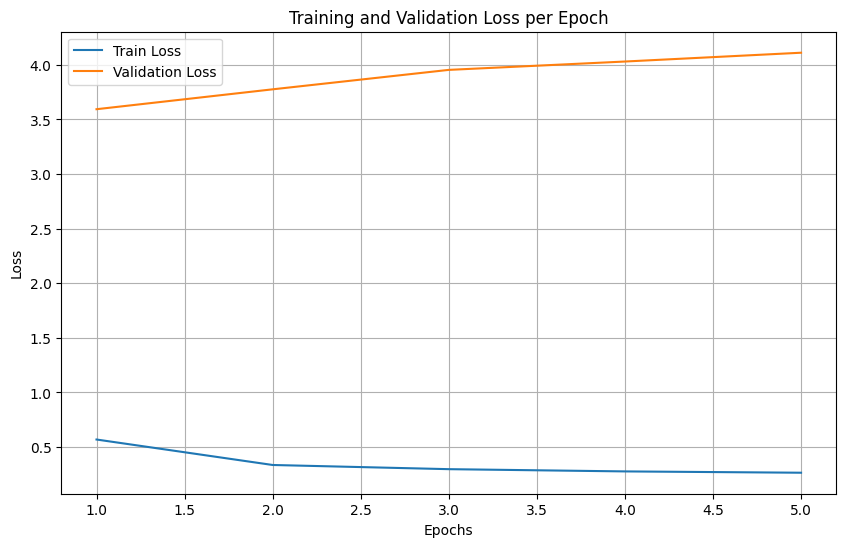

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import sentencepiece as spm
import time
import math
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts


train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')
dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')
test_sequences, test_texts = load_full_data('/content/drive/My Drive/proj/sequences_test.npy', '/content/drive/My Drive/proj/texts_test.json')

with open('train_texts.txt', 'w') as f:
    for sentence in train_texts:
        f.write(sentence + '\n')

# Train a SentencePiece model
spm.SentencePieceTrainer.train(
    input='train_texts.txt',
    model_prefix='spm',
    vocab_size=1200,
    model_type='bpe',
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

sp = spm.SentencePieceProcessor(model_file='spm.model')

vocab_size = len(sp)

def sp_tokenizer(text):
    return sp.encode(text, out_type=int)

class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32).to(device)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long).to(device)
        return sequence, text_tokens

def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)
    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

BATCH_SIZE = 32
INPUT_DIM = 1024

train_dataset = LandmarksDataset(train_sequences, train_texts, sp_tokenizer)
dev_dataset = LandmarksDataset(dev_sequences, dev_texts, sp_tokenizer)
test_dataset = LandmarksDataset(test_sequences, test_texts, sp_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: collate_fn(x, pad_idx=0, input_dim=INPUT_DIM))
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx=0, input_dim=INPUT_DIM))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx=0, input_dim=INPUT_DIM))

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.2)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.2,
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(src))
        tgt = self.positional_encoding(self.layer_norm(tgt))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

def evaluate_and_metrics(model, loader, device, pad_idx, sp):
    model.eval()
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    all_targets, all_predictions = [], []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])
            loss = criterion(outputs.view(-1, outputs.size(-1)), texts[:, 1:].reshape(-1))
            total_loss += loss.item()

            preds = outputs.argmax(dim=-1).cpu().numpy()
            all_predictions.extend(preds)
            all_targets.extend(texts[:, 1:].cpu().numpy())

    avg_loss = total_loss / len(loader)
    metrics = {'avg_loss': avg_loss}

    # BLEU and ROUGE
    smoothing = SmoothingFunction().method4
    bleu_scores = {"BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": []}
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {"ROUGE-1": [], "ROUGE-2": [], "ROUGE-L": []}

    for ref, hyp in zip(all_targets, all_predictions):
        ref_tokens = nltk.word_tokenize(sp.decode_ids([int(t) for t in ref if t != pad_idx]))
        hyp_tokens = nltk.word_tokenize(sp.decode_ids([int(p) for p in hyp if p != pad_idx]))
        bleu_scores["BLEU-1"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-2"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-3"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-4"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

        rouge_score = rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))
        rouge_scores["ROUGE-1"].append(rouge_score['rouge1'].fmeasure)
        rouge_scores["ROUGE-2"].append(rouge_score['rouge2'].fmeasure)
        rouge_scores["ROUGE-L"].append(rouge_score['rougeL'].fmeasure)

    avg_bleu_scores = {key: np.mean(value) for key, value in bleu_scores.items()}
    avg_rouge_scores = {key: np.mean(value) for key, value in rouge_scores.items()}

    metrics.update(avg_bleu_scores)
    metrics.update(avg_rouge_scores)

    return metrics

model = TransformerModel(INPUT_DIM, 512, 4, 1, vocab_size).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)
num_epochs = 5

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for sequences, texts in train_loader:
        sequences, texts = sequences.to(device), texts.to(device)
        optimizer.zero_grad()
        outputs = model(sequences, texts[:, :-1])
        loss = criterion(outputs.view(-1, outputs.size(-1)), texts[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    val_metrics = evaluate_and_metrics(model, dev_loader, device, pad_idx=0, sp=sp)
    epoch_time = time.time() - start_time

    train_losses.append(avg_epoch_loss)
    val_losses.append(val_metrics["avg_loss"])

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_metrics["avg_loss"]:.4f}, Epoch Time: {epoch_time:.2f}s')


test_metrics = evaluate_and_metrics(model, test_loader, device, pad_idx=0, sp=sp)
print(f"\nFinal Test Metrics:")
print(f"Test Loss: {test_metrics['avg_loss']:.4f}")
for key in ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L']:
    print(f"{key}: {test_metrics[key]:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Print model summary of Idea 2: subword tokenisation
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

TransformerModel(
  (embedding): Linear(in_features=1024, out_features=512, bias=True)
  (target_embedding): Embedding(1200, 512)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): Layer

**The code below is to extract the morphological features and save them in .json file for later use**

In [ ]:
import spacy
import json
import numpy as np

nlp = spacy.load('de_core_news_sm')

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')

morphological_features = {}

for gloss in set(" ".join(train_texts).split()):
    doc = nlp(gloss)
    for token in doc:
        morph = token.morph.to_dict()
        morphological_features[gloss] = morph

with open('morphological_features.json', 'w') as f:
    json.dump(morphological_features, f, indent=2)

print("Morphological features have been extracted and saved.")


Morphological features have been extracted and saved.


In [ ]:
import json
from collections import Counter

with open('morphological_features.json', 'r') as f:
    morphological_features = json.load(f)

feature_counts = Counter()

for gloss, features in morphological_features.items():
    for feature_name, feature_value in features.items():
        feature_counts[(feature_name, feature_value)] += 1

total_feature_occurrences = sum(feature_counts.values())

feature_weights = {}

for feature, count in feature_counts.items():
    feature_weights[feature] = total_feature_occurrences / count

max_weight = max(feature_weights.values())
for feature in feature_weights:
    feature_weights[feature] /= max_weight

for feature, weight in feature_weights.items():
    print(f"Feature: {feature}, Weight: {weight:.4f}")


**The code below is to extract correctly predicted glosses**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import nltk
import math


nltk.download('punkt')

def build_vocab(texts):
    words = set()
    for text in texts:
        words.update(text.split())
    vocab = {word: idx for idx, word in enumerate(sorted(words))}
    vocab['<pad>'] = len(vocab)
    return vocab

def decode_text(output, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    decoded_texts = []
    for seq in output:
        decoded_text = ' '.join([inv_vocab[token] for token in seq if token in inv_vocab and inv_vocab[token] != '<pad>'])
        decoded_texts.append(decoded_text)
    return decoded_texts

# Func to extract generated sentences from the Transformer model
def extract_generated_sentences(model, loader, device, vocab):
    model.eval()
    generated_sentences = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])

            predicted_tokens = outputs.argmax(dim=-1).cpu().numpy()
            generated_sentences.extend(decode_text(predicted_tokens, vocab))

    return generated_sentences

# match generated and reference sentences to extract correctly predicted glosses
def align_sentences(generated_sentence, reference_sentence):
    generated_tokens = nltk.word_tokenize(generated_sentence)
    reference_tokens = nltk.word_tokenize(reference_sentence)

    correct_glosses = []
    for gen, ref in zip(generated_tokens, reference_tokens):
        if gen == ref:
            correct_glosses.append(gen)

    return correct_glosses

def get_correct_predictions(generated_sentences, reference_sentences):
    correct_predictions = []

    for generated_sentence, reference_sentence in zip(generated_sentences, reference_sentences):
        correct_glosses = align_sentences(generated_sentence, reference_sentence)
        correct_predictions.extend(correct_glosses)

    return correct_predictions

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

sequences, texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')


vocab = build_vocab(texts)
pad_idx = vocab['<pad>']

INPUT_DIM = 1024
EMBED_DIM = 512
NUM_HEADS = 4  # Updated to 4 heads
NUM_LAYERS = 1  # 1 layer
OUTPUT_DIM = len(vocab)
BATCH_SIZE = 64

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(self.dropout(src)))
        tgt = self.positional_encoding(self.layer_norm(self.dropout(tgt)))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long)
        return sequence, text_tokens

def word_tokenizer(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')

dev_dataset = LandmarksDataset(dev_sequences, dev_texts, lambda text: word_tokenizer(text, vocab))
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=2, pin_memory=True)

model = TransformerModel(INPUT_DIM, EMBED_DIM, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM)
model.load_state_dict(torch.load('/content/drive/My Drive/proj/transformer_1Layer_4Head.pth', map_location=torch.device('cpu')))
model.eval()
model = model.to(device)

generated_sentences = extract_generated_sentences(model, dev_loader, device, vocab)

# Load ref sentences
reference_json_path = '/content/drive/My Drive/proj/texts_dev.json'
with open(reference_json_path, 'r') as f:
    reference_sentences = json.load(f)

# Get correctly predicted glosses
correct_predictions = get_correct_predictions(generated_sentences, reference_sentences)

print("Correctly Predicted Glosses:")
print(correct_predictions)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
<ipython-input-1-2ee7534a8b62>:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this expe

Correctly Predicted Glosses:
['dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'dezember', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'oktober', 'ok

**The code below is to make dict. of correctly predicted glosses and their counts**

In [ ]:
from collections import Counter

# make a dict. of correctly preicted glosses and their counts
correct_predictions_counter = Counter(correct_predictions)

print("Correctly Predicted Glosses with Counts:")
print(correct_predictions_counter)


Correctly Predicted Glosses with Counts:
Counter({'es': 209, 'norddeutschland': 194, 'bleibt': 167, 'dann': 167, 'und': 152, 'deutschland': 116, 'eine': 116, 'regen': 111, 'oktober': 89, 'dezember': 54, 'weiter': 35, 'morgen': 27})


**The code below is to get features based on correctly predicted glosses.**

In [ ]:
import json
from collections import defaultdict, Counter

with open('/content/morphological_features.json', 'r') as f:
    morphological_features = json.load(f)

# Correctly Predicted Glosses with Counts
correct_predictions_counter = Counter({
    'es': 209,
    'norddeutschland': 194,
    'bleibt': 167,
    'dann': 167,
    'und': 152,
    'deutschland': 116,
    'eine': 116,
    'regen': 111,
    'oktober': 89,
    'dezember': 54,
    'weiter': 35,
    'morgen': 27
})

feature_weights = defaultdict(float)

for gloss, count in correct_predictions_counter.items():
    if gloss in morphological_features:
        features = morphological_features[gloss]
        for feature in features:
            feature_weights[feature] += count

feature_weights = dict(feature_weights)

print("Feature Weights based on Correct Predictions:")
for feature, weight in feature_weights.items():
    print(f"{feature}: {weight:.4f}")


Feature Weights based on Correct Predictions:
Case: 889.0000
Gender: 889.0000
Number: 1056.0000
Person: 376.0000
PronType: 325.0000
Mood: 167.0000
Tense: 167.0000
VerbForm: 167.0000
Definite: 116.0000


**The code below is to normalise the morphological feature weights**

In [ ]:
# Normalize the feature weights
total_weight = sum(feature_weights.values())
normalized_feature_weights = {k: v / total_weight for k, v in feature_weights.items()}

print("Normalized Feature Weights:")
for feature, weight in normalized_feature_weights.items():
    print(f"{feature}: {weight:.4f}")


Normalized Feature Weights:
Case: 0.2141
Gender: 0.2141
Number: 0.2543
Person: 0.0906
PronType: 0.0783
Mood: 0.0402
Tense: 0.0402
VerbForm: 0.0402
Definite: 0.0279


**The code below is to map morph features based on vocab**

In [ ]:
# Load morph features from the JSON file
json_file_path = '/content/drive/My Drive/proj/gloss_morph_features.json'

with open(json_file_path, 'r') as f:
    gloss_morph_data = json.load(f)

# Map glosses to their morph features based on vocab
gloss_morph_features = {}
for gloss, features in gloss_morph_data.items():
    if gloss in vocab:
        gloss_morph_features[vocab[gloss]] = features


**The code below is for Idea 3: morph feature aware training. Attempt #1**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import nltk
import math
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from collections import Counter
import time

# Ensure NLTK data is available
nltk.download('punkt')

# Load sequences and texts for the entire dataset
def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

# Define a custom dataset
class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long)
        return sequence, text_tokens

# Function to tokenize text using vocabulary
def word_tokenizer(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

# Custom collate function to handle padding and ensure correct dimensions
def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    # Ensure sequences have the correct dimension (N, 1024)
    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

# Build a word vocabulary
def build_vocab(texts):
    words = set()
    for text in texts:
        words.update(text.split())
    vocab = {word: idx for idx, word in enumerate(sorted(words))}
    vocab['<pad>'] = len(vocab)
    return vocab

# Model architecture
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(self.dropout(src)))
        tgt = self.positional_encoding(self.layer_norm(self.dropout(tgt)))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output


class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, feature_weights, pad_idx):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.feature_weights = feature_weights
        self.pad_idx = pad_idx

    def forward(self, outputs, targets, gloss_morph_features):
        # Use reshape instead of view to avoid runtime errors
        loss = nn.CrossEntropyLoss(reduction='none')(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        gloss_weights = torch.ones_like(targets, dtype=torch.float32)
        for gloss, features in gloss_morph_features.items():
            gloss_weight = sum(self.feature_weights.get(feature, 1.0) for feature in features)
            gloss_weights[targets == gloss] = gloss_weight
        gloss_weights[targets == self.pad_idx] = 0
        loss = (loss * gloss_weights.reshape(-1)).mean()
        return loss


# Load data and prepare the vocabulary
train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')
dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')
test_sequences, test_texts = load_full_data('/content/drive/My Drive/proj/sequences_test.npy', '/content/drive/My Drive/proj/texts_test.json')

# Build vocabulary and prepare data loaders
vocab = build_vocab(train_texts + dev_texts + test_texts)
pad_idx = vocab['<pad>']

train_dataset = LandmarksDataset(train_sequences, train_texts, lambda text: word_tokenizer(text, vocab))
dev_dataset = LandmarksDataset(dev_sequences, dev_texts, lambda text: word_tokenizer(text, vocab))
test_dataset = LandmarksDataset(test_sequences, test_texts, lambda text: word_tokenizer(text, vocab))

BATCH_SIZE = 64
INPUT_DIM = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=0, pin_memory=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=0, pin_memory=False)

# Prepare morphological feature weights (you need to load gloss_morph_features from your .json file)
# Load morphological features from the JSON file
json_file_path = '/content/drive/My Drive/proj/morphological_features.json'

with open(json_file_path, 'r') as f:
    gloss_morph_data = json.load(f)

# Map glosses to their morphological features based on vocabulary
gloss_morph_features = {}
for gloss, features in gloss_morph_data.items():
    if gloss in vocab:
        gloss_morph_features[vocab[gloss]] = features


# Example feature weights (these should be the normalized values from earlier)
feature_weights = {
    'Case': 0.2141,
    'Gender': 0.2141,
    'Number': 0.2543,
    'Person': 0.0906,
    'PronType': 0.0783,
    'Mood': 0.0402,
    'Tense': 0.0402,
    'VerbForm': 0.0402,
    'Definite': 0.0279
}

# Initialize the model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(INPUT_DIM, 512, 4, 1, len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = WeightedCrossEntropyLoss(feature_weights, ignore_index=pad_idx)

# Function to decode the model's output back to text
def decode_text(output, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    decoded_texts = []
    for seq in output:
        decoded_text = ' '.join([inv_vocab[token] for token in seq if token in inv_vocab and inv_vocab[token] != '<pad>'])
        decoded_texts.append(decoded_text)
    return decoded_texts

# Function to evaluate model performance
def evaluate_and_metrics(model, loader, device, pad_idx, gloss_morph_features):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])
            loss = criterion(outputs, texts[:, 1:], gloss_morph_features)
            total_loss += loss.item()

            predicted_tokens = outputs.argmax(dim=-1)
            all_predictions.extend(predicted_tokens.cpu().numpy())
            all_targets.extend(texts[:, 1:].cpu().numpy())

    avg_loss = total_loss / len(loader)

    smoothing = SmoothingFunction().method4
    bleu_scores = {"BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": []}
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {"ROUGE-1": [], "ROUGE-2": [], "ROUGE-L": []}

    for ref, hyp in zip(all_targets, all_predictions):
        ref_tokens = nltk.word_tokenize(decode_text([ref], vocab)[0])
        hyp_tokens = nltk.word_tokenize(decode_text([hyp], vocab)[0])

        bleu_scores["BLEU-1"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-2"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-3"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-4"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

        rouge_scores["ROUGE-1"].append(rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))['rouge1'].fmeasure)
        rouge_scores["ROUGE-2"].append(rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))['rouge2'].fmeasure)
        rouge_scores["ROUGE-L"].append(rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))['rougeL'].fmeasure)

    return {
        'avg_loss': avg_loss,
        'bleu_scores': bleu_scores,
        'rouge_scores': rouge_scores
    }

# Training loop and evaluation
num_epochs = 5
best_val_loss = float('inf')
early_stopping_counter = 0
patience = 2  # Early stopping patience

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for sequences, texts in train_loader:
        sequences, texts = sequences.to(device), texts.to(device)
        optimizer.zero_grad()
        outputs = model(sequences, texts[:, :-1])
        loss = criterion(outputs, texts[:, 1:], gloss_morph_features)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    val_metrics = evaluate_and_metrics(model, dev_loader, device, pad_idx, gloss_morph_features)
    epoch_time = time.time() - start_time

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_metrics["avg_loss"]:.4f}, Epoch Time: {epoch_time:.2f}s')

    # Early stopping
    if val_metrics['avg_loss'] < best_val_loss:
        best_val_loss = val_metrics['avg_loss']
        early_stopping_counter = 0
        # Save the best model (if needed)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping due to no improvement in validation loss.")
            break

# Final evaluation on test data
test_metrics = evaluate_and_metrics(model, test_loader, device, pad_idx, gloss_morph_features)

# Print final test metrics
print("\nFinal Test Metrics:")
print(f"Test Loss: {test_metrics['avg_loss']:.4f}")
print(f"BLEU-1: {np.mean(test_metrics['bleu_scores']['BLEU-1']):.4f}")
print(f"BLEU-2: {np.mean(test_metrics['bleu_scores']['BLEU-2']):.4f}")
print(f"BLEU-3: {np.mean(test_metrics['bleu_scores']['BLEU-3']):.4f}")
print(f"BLEU-4: {np.mean(test_metrics['bleu_scores']['BLEU-4']):.4f}")
print(f"ROUGE-1: {np.mean(test_metrics['rouge_scores']['ROUGE-1']):.4f}")
print(f"ROUGE-2: {np.mean(test_metrics['rouge_scores']['ROUGE-2']):.4f}")
print(f"ROUGE-L: {np.mean(test_metrics['rouge_scores']['ROUGE-L']):.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/5], Train Loss: 0.0672, Val Loss: 1.6279, Epoch Time: 750.46s
Epoch [2/5], Train Loss: 0.0464, Val Loss: 1.7705, Epoch Time: 753.08s
Epoch [3/5], Train Loss: 0.0446, Val Loss: 1.8374, Epoch Time: 749.40s
Early stopping due to no improvement in validation loss.

Final Test Metrics:
Test Loss: 1.9645
BLEU-1: 0.4436
BLEU-2: 0.2539
BLEU-3: 0.1575
BLEU-4: 0.1005
ROUGE-1: 0.4688
ROUGE-2: 0.2013
ROUGE-L: 0.4146


**The code below is for idea 3: morphological feature aware traning.**





[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/5], Train Loss: 0.0643, Val Loss: 1.6421, Epoch Time: 758.69s
Epoch [2/5], Train Loss: 0.0456, Val Loss: 1.8372, Epoch Time: 761.80s
Epoch [3/5], Train Loss: 0.0431, Val Loss: 1.8859, Epoch Time: 766.94s
Epoch [4/5], Train Loss: 0.0414, Val Loss: 1.9346, Epoch Time: 764.72s
Epoch [5/5], Train Loss: 0.0397, Val Loss: 1.9855, Epoch Time: 758.58s
TransformerModel(
  (embedding): Linear(in_features=1024, out_features=512, bias=True)
  (target_embedding): Embedding(2113, 512)
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
       

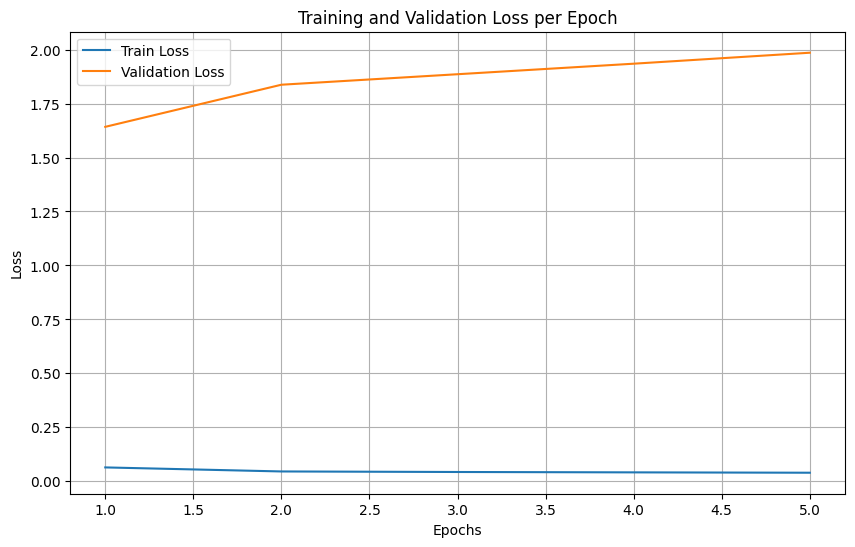

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
import nltk
import math
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import time

# Ensure NLTK data is available
nltk.download('punkt')

# Load sequences and texts for the entire dataset
def load_full_data(sequence_file, text_file):
    with open(sequence_file, 'rb') as sf, open(text_file, 'r') as tf:
        sequences = np.load(sf, allow_pickle=True).tolist()
        texts = json.load(tf)
    return sequences, texts

# Define a custom dataset
class LandmarksDataset(Dataset):
    def __init__(self, sequences, texts, tokenizer):
        self.sequences = sequences
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        text = self.texts[idx]
        text_tokens = torch.tensor(self.tokenizer(text), dtype=torch.long)
        return sequence, text_tokens

# Function to tokenize text using vocabulary
def word_tokenizer(text, vocab):
    return [vocab[word] for word in text.split() if word in vocab]

# Custom collate function to handle padding and ensure correct dimensions
def collate_fn(batch, pad_idx, input_dim):
    sequences, texts = zip(*batch)

    sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)
    texts_padded = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)

    # Ensure sequences have the correct dimension (N, 1024)
    if sequences_padded.size(2) != input_dim:
        pad_size = input_dim - sequences_padded.size(2)
        sequences_padded = torch.nn.functional.pad(sequences_padded, (0, pad_size))

    return sequences_padded, texts_padded

# Build a word vocabulary
def build_vocab(texts):
    words = set()
    for text in texts:
        words.update(text.split())
    vocab = {word: idx for idx, word in enumerate(sorted(words))}
    vocab['<pad>'] = len(vocab)
    return vocab

# Model architecture
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.target_embedding = nn.Embedding(output_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.transformer = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=2048,
            dropout=0.1,
            activation='relu',
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.fc_out = nn.Linear(embed_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.target_embedding.weight)
        nn.init.xavier_uniform_(self.fc_out.weight)
        for p in self.transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, tgt):
        src = self.embedding(src.float())
        tgt = self.target_embedding(tgt.long())
        src = self.positional_encoding(self.layer_norm(src))
        tgt = self.positional_encoding(self.layer_norm(tgt))
        output = self.transformer(src, tgt)
        output = self.fc_out(output)
        return output

# Load morphological features from the JSON file
json_file_path = '/content/drive/My Drive/proj/morphological_features.json'

with open(json_file_path, 'r') as f:
    gloss_morph_data = json.load(f)

# Example feature weights (these should be the normalized values)
feature_weights = {
    'Case': 0.2141,
    'Gender': 0.2141,
    'Number': 0.2543,
    'Person': 0.0906,
    'PronType': 0.0783,
    'Mood': 0.0402,
    'Tense': 0.0402,
    'VerbForm': 0.0402,
    'Definite': 0.0279
}

# Weighted CrossEntropy Loss
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, feature_weights, pad_idx):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.feature_weights = feature_weights
        self.pad_idx = pad_idx

    def forward(self, outputs, targets, gloss_morph_features):
        loss = nn.CrossEntropyLoss(reduction='none')(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        gloss_weights = torch.ones_like(targets, dtype=torch.float32)
        for gloss, features in gloss_morph_features.items():
            gloss_weight = sum(self.feature_weights.get(feature, 1.0) for feature in features)
            gloss_weights[targets == gloss] = gloss_weight
        gloss_weights[targets == self.pad_idx] = 0
        loss = (loss * gloss_weights.reshape(-1)).mean()
        return loss

# Function to decode the model's output back to text
def decode_text(output, vocab):
    inv_vocab = {v: k for k, v in vocab.items()}
    decoded_texts = []
    for seq in output:
        decoded_text = ' '.join([inv_vocab[token] for token in seq if token in inv_vocab and inv_vocab[token] != '<pad>'])
        decoded_texts.append(decoded_text)
    return decoded_texts

# Function to evaluate model performance
def evaluate_and_metrics(model, loader, device, pad_idx, gloss_morph_features):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for sequences, texts in loader:
            sequences, texts = sequences.to(device), texts.to(device)
            outputs = model(sequences, texts[:, :-1])
            loss = criterion(outputs, texts[:, 1:], gloss_morph_features)
            total_loss += loss.item()

            predicted_tokens = outputs.argmax(dim=-1)
            all_predictions.extend(predicted_tokens.cpu().numpy())
            all_targets.extend(texts[:, 1:].cpu().numpy())

    avg_loss = total_loss / len(loader)

    smoothing = SmoothingFunction().method4
    bleu_scores = {"BLEU-1": [], "BLEU-2": [], "BLEU-3": [], "BLEU-4": []}
    rouge_scorer_inst = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {"ROUGE-1": [], "ROUGE-2": [], "ROUGE-L": []}

    for ref, hyp in zip(all_targets, all_predictions):
        ref_tokens = nltk.word_tokenize(decode_text([ref], vocab)[0])
        hyp_tokens = nltk.word_tokenize(decode_text([hyp], vocab)[0])

        bleu_scores["BLEU-1"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-2"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-3"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing))
        bleu_scores["BLEU-4"].append(sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing))

        rouge_scores["ROUGE-1"].append(rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))['rouge1'].fmeasure)
        rouge_scores["ROUGE-2"].append(rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))['rouge2'].fmeasure)
        rouge_scores["ROUGE-L"].append(rouge_scorer_inst.score(' '.join(ref_tokens), ' '.join(hyp_tokens))['rougeL'].fmeasure)

    return {
        'avg_loss': avg_loss,
        'bleu_scores': bleu_scores,
        'rouge_scores': rouge_scores
    }

# Load the data
train_sequences, train_texts = load_full_data('/content/drive/My Drive/proj/sequences.npy', '/content/drive/My Drive/proj/texts.json')
dev_sequences, dev_texts = load_full_data('/content/drive/My Drive/proj/sequences_dev.npy', '/content/drive/My Drive/proj/texts_dev.json')
test_sequences, test_texts = load_full_data('/content/drive/My Drive/proj/sequences_test.npy', '/content/drive/My Drive/proj/texts_test.json')

# Build vocabulary and prepare data loaders
vocab = build_vocab(train_texts + dev_texts + test_texts)
pad_idx = vocab['<pad>']

train_dataset = LandmarksDataset(train_sequences, train_texts, lambda text: word_tokenizer(text, vocab))
dev_dataset = LandmarksDataset(dev_sequences, dev_texts, lambda text: word_tokenizer(text, vocab))
test_dataset = LandmarksDataset(test_sequences, test_texts, lambda text: word_tokenizer(text, vocab))

BATCH_SIZE = 64
INPUT_DIM = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=0, pin_memory=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: collate_fn(x, pad_idx, INPUT_DIM), num_workers=0, pin_memory=False)

# Map glosses to their morphological features based on vocabulary
gloss_morph_features = {}
for gloss, features in gloss_morph_data.items():
    if gloss in vocab:
        gloss_morph_features[vocab[gloss]] = features

# Initialize the model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModel(INPUT_DIM, 512, 4, 1, len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = WeightedCrossEntropyLoss(feature_weights, pad_idx)

# Training loop and evaluation
num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for sequences, texts in train_loader:
        sequences, texts = sequences.to(device), texts.to(device)
        optimizer.zero_grad()
        outputs = model(sequences, texts[:, :-1])
        loss = criterion(outputs, texts[:, 1:], gloss_morph_features)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    val_metrics = evaluate_and_metrics(model, dev_loader, device, pad_idx, gloss_morph_features)
    val_losses.append(val_metrics['avg_loss'])
    train_losses.append(avg_epoch_loss)

    epoch_time = time.time() - start_time

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Val Loss: {val_metrics["avg_loss"]:.4f}, Epoch Time: {epoch_time:.2f}s')

# Final evaluation on test data
test_metrics = evaluate_and_metrics(model, test_loader, device, pad_idx, gloss_morph_features)

# Print model summary of Idea 2: subword tokenisation
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

# Print final test metrics
print("\nFinal Test Metrics:")
print(f"Test Loss: {test_metrics['avg_loss']:.4f}")
print(f"BLEU-1: {np.mean(test_metrics['bleu_scores']['BLEU-1']):.4f}")
print(f"BLEU-2: {np.mean(test_metrics['bleu_scores']['BLEU-2']):.4f}")
print(f"BLEU-3: {np.mean(test_metrics['bleu_scores']['BLEU-3']):.4f}")
print(f"BLEU-4: {np.mean(test_metrics['bleu_scores']['BLEU-4']):.4f}")
print(f"ROUGE-1: {np.mean(test_metrics['rouge_scores']['ROUGE-1']):.4f}")
print(f"ROUGE-2: {np.mean(test_metrics['rouge_scores']['ROUGE-2']):.4f}")
print(f"ROUGE-L: {np.mean(test_metrics['rouge_scores']['ROUGE-L']):.4f}")

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()
